# **Titanic - Machine Learning from Disaster**

### **Steps**
1. Import and profile data
2. Transform categorical variables
3. Correlation Matrix
4. Feature Engineering, Impute, Bin Features
5. Add Interactions
6. Score Models
7. Tune Hyper Parameters - if necessary
8. Calculate Model Probabilities
9. Create Ensemble Models
10. Calculate Model Performance Metrics
11. Select Final Model
12. Submit to Kaggle
13. Compare Public Score with Leaderboard

### **Workflow**
First, **iterate** thru steps 1, 2, 3, 4, and 6 to determine:
1. To hot-encode or not.
2. To bin features or not.
3. Use fare or do a log transformation.
4. Best way to impute missing features.
5. Include Family Size or not.
6. How to group tickets and titles.

Once enough progress was made then turned to tuning the hyper parameters by **running** steps 1, 2, 3, 4, 6, 7, 8, and 10.
**SVC** emerged as the best model while the Random Forest, Decision Tree, and XGBoost all showed evidence of overfitting.

Decided to **store models in a dictionary** to make it easier to **iterate** thru models and to explore if some models 
worked better with scaled features or not.

Next, decided to explore **feature interactions (step 5)** and **iterated** thru steps 1, 2, 3, 4, 5, 6, 7, 8, and 10 to 
determine which interactions to include. Decided to focus on the features with highest importance based on the 
findings from **step 7 (hyper-parameter).**

Finally, observed that SVC is good at predicting true non survivors, but other models good at predicting survivors, 
so decided to build several ensemble models and **running** steps 1 thru 10.

An **Ensemble Model** made up of SVC and a Random Forest Model with tuned hyper-parameters was an improvement over the **SVC** across 
most cv metrics but yielded a lower Public Score.

### **Findings**
1. Categorical features performed better if they are one-hot encoded.
2. Continuous features like Fare, Age, and Family Size performed better as continuous instead of as bins.
3. Doing this results in an above median-model with a public score of **0.79186**.
4. Adding feature interactions provided gains, but the impact was minimal.
5. No need to iterate over hyper-parameters for further gains. Run study and settle on best parameters.
6. Adding ensemble models resulted in big improvement in cv metrics, but a lower public score of **78468**.

In [1]:
import os, pandas as pd, numpy as np, random, seaborn as sns, matplotlib.pyplot as plt, warnings, re, itertools, optuna
import matplotlib.ticker as mtick
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, roc_curve, roc_auc_score

plot_title_dict = {'fontsize': 18, 'fontweight': 'bold'}
plot_axis_dict = {'fontsize': 12, 'fontweight': 'bold'}

# Function to plot survival rate by feature
def surv_percent_fun(col_name, fig_size):    
    counts_df = train_df\
        .groupby([col_name], as_index = False)\
        .agg(Count = (col_name, 'count'))

    surv_pct_df = train_df\
        .groupby([col_name, 'Survived'], as_index = False)\
        .agg(Count = (col_name, 'count'))\
        .pivot(index = col_name, columns = 'Survived', values = 'Count')\
        .fillna(0)
    surv_pct_df['Total'] = surv_pct_df[0] + surv_pct_df[1]
    surv_pct_df[0] = surv_pct_df[0] / surv_pct_df['Total']
    surv_pct_df[1] = surv_pct_df[1] / surv_pct_df['Total']
    del surv_pct_df['Total']
    surv_pct_df = surv_pct_df[surv_pct_df.columns[::-1]]

    fig, ax = plt.subplots(figsize = fig_size)
    surv_pct_df.plot(kind = 'bar', stacked = True, color = ['lightblue', 'grey'], ax = ax)
    plt.title('Survival Rates by ' + col_name.replace('_', ' '), fontdict = plot_title_dict)
    plt.ylabel('Survival Rate', fontdict = plot_axis_dict)
    plt.xlabel(col_name.replace('_', ' ') + ' (Count)', fontdict = plot_axis_dict)
    ax.set_xticklabels([str(t) + ' (' + str(c) + ')' for t, c in zip(counts_df[col_name], counts_df['Count'])])
    ax.tick_params(axis = 'x', labelrotation = 0)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
    plt.grid(axis = 'y')
    return

# Function to plot feature importance
def feature_importance_fun(model):
    feature_imp = pd.DataFrame({'feature': X_train.columns, 
                                'importance': np.round(model_dict[model]['Model'].feature_importances_,3)})
    feature_imp = feature_imp.sort_values('importance', ascending = False).set_index('feature')

    f, ax = plt.subplots(figsize = (12, 6))
    feature_imp.plot.bar(ax = ax)
    plt.title(model + ' Feature Importance', fontdict = plot_title_dict)
    plt.ylabel('Importance', fontdict = plot_axis_dict)
    plt.xlabel('Feature', fontdict = plot_axis_dict)
    plt.show()

/Users/andressanchez/micromamba/envs/anfield_west/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Import and profile data

First adjust path if running locally and create kaggle environment bool to skip some steps

4 features have missing values: Cabin (1,014), Age (263), Embarked (2), Fare (1)

In [2]:
kaggle_path = '/kaggle/input'
kaggle_env = os.path.exists(kaggle_path)

if kaggle_env == False:
    kaggle_path = '.' + kaggle_path

In [3]:
train_df = pd.read_csv(kaggle_path + '/titanic/train.csv')
test_df = pd.read_csv(kaggle_path + '/titanic/test.csv')
df_list = [train_df, test_df]

# Copy for plots
#plot_df = train_df.copy()[['Survived', 'Age', 'Embarked', 'Pclass', 'Sex', 'SibSp', 'Parch']]
plot_list = [train_df.copy(), test_df.copy()]
plot_df = plot_list[0]

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
for df in df_list:
    df.info()
    print(' ')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass

In [5]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train_df.describe(include = ['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [7]:
pd.concat([train_df, test_df]).isnull().sum().sort_values(ascending = False)

Cabin          1014
Survived        418
Age             263
Embarked          2
Fare              1
PassengerId       0
Pclass            0
Name              0
Sex               0
SibSp             0
Parch             0
Ticket            0
dtype: int64

# 2. Transform Categorical Variables

# 2.1. Ticket

1. Create ticket group based on alphabetic characters in ticket
2. Map groups only if ticket characters are in both sets
3. One hot encode ticket group
4. Feature Engineering: ticket frequency

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TicketIsNumeric,Ticket_Alpha,Ticket_Group
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False,A/5,A
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,False,PC,P
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False,STON/O2,Soton
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,True,113803,Numeric
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,True,373450,Numeric


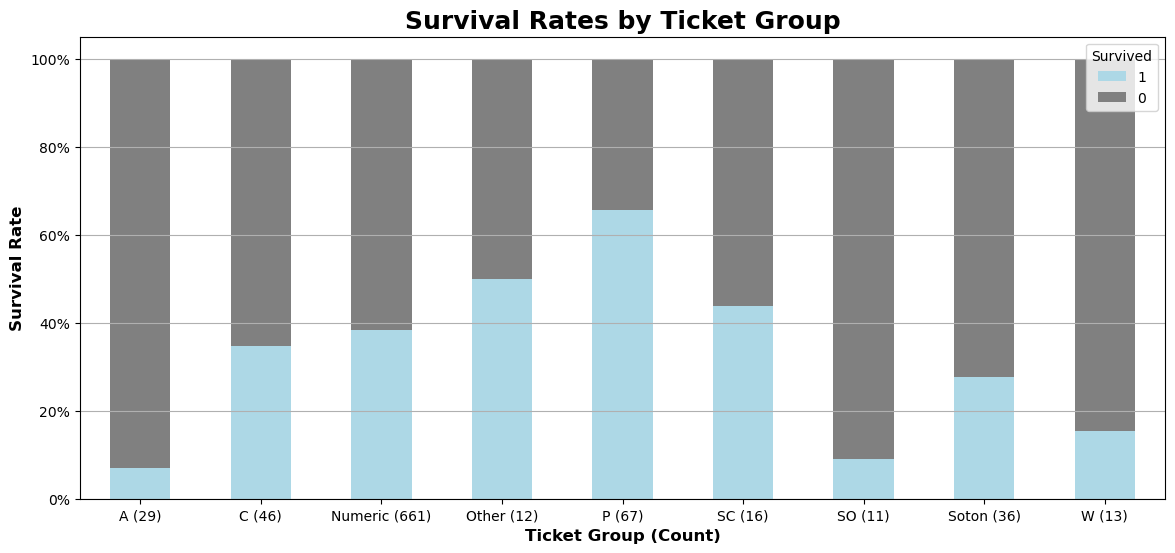

In [8]:
tickets_dict = {'A': ['A', 'A/5', 'A5', 'A/4', 'A4', 'A/S', 'AQ/3', 'AQ/4'],
                'C': ['CA', 'C'],
                'P': ['PC', 'PP', 'P/PP', 'SW/PP'],
                'SC': ['SC/PARIS', 'SC/AH', 'SC/A4', 'SC/AH BASLE', 'SC/A3', 'SCO/W'], 
                'SO': ['SOC', 'SO/PP', 'SO/C', 'SOP', 'SP'], 
                # 'Soton': ['SOTON/OQ', 'SOTON/O2', 'CA/SOTON'], 
                # 'Ston': ['STON/O', 'STON/O2', 'STON/OQ'], 
                'Soton': ['SOTON/OQ', 'SOTON/O2', 'CA/SOTON', 'STON/O', 'STON/O2', 'STON/OQ'], 
                'W': ['W/C', 'WE/P', 'WEP']}
tickets_alpha = list(itertools.chain(*[v for v in tickets_dict.values()]))

for df in df_list:
    df['TicketIsNumeric'] = [t.isnumeric() for t in df['Ticket']]    
    df['Ticket_Alpha'] = [t.upper().replace('.', '') for t in df['Ticket']]
    df['Ticket_Alpha'] = [re.sub(r' \d+', '', t) for t in df['Ticket_Alpha']]
    df['Ticket_Alpha_Group'] = ['Other' if t not in tickets_alpha else t for t in df['Ticket_Alpha']]
    df['Ticket_Group'] = 'Missing'
    df.loc[df['TicketIsNumeric'], 'Ticket_Group'] = 'Numeric'
    df.loc[df['Ticket_Group'] == 'Missing', 'Ticket_Group'] = df['Ticket_Alpha_Group']
    for d in tickets_dict:
        df['Ticket_Group'] = df['Ticket_Group'].replace(tickets_dict[d], d) 
    df.drop(['Ticket_Alpha_Group'], axis = 1, inplace = True)

surv_percent_fun('Ticket_Group', (14, 6))
train_df.head()

In [9]:
ticket_train_df = train_df[train_df['TicketIsNumeric'] == False]\
    .groupby(['Ticket_Alpha', 'Ticket_Group'], as_index = False)\
    .agg(Count = ('Ticket_Alpha', 'count'))
ticket_train_df['Set'] = 'Train'

ticket_test_df = test_df[test_df['TicketIsNumeric'] == False]\
    .groupby(['Ticket_Alpha', 'Ticket_Group'], as_index = False)\
    .agg(Count = ('Ticket_Alpha', 'count'))
ticket_test_df['Set'] = 'Test'

pd.concat([ticket_train_df, ticket_test_df])\
    .pivot(index = ['Ticket_Group', 'Ticket_Alpha'], columns = 'Set', values = 'Count')\
    .sort_values(by = ['Ticket_Group', 'Train'], ascending = False)

Set                        Test  Train
Ticket_Group Ticket_Alpha             
W            W/C            5.0   10.0
             WE/P           NaN    2.0
             WEP            1.0    1.0
Soton        SOTON/OQ       9.0   15.0
             STON/O         2.0   12.0
             STON/O2        1.0    6.0
             SOTON/O2       1.0    2.0
             CA/SOTON       NaN    1.0
             STON/OQ        1.0    NaN
SO           SOC            2.0    5.0
             SO/PP          4.0    3.0
             SO/C           NaN    1.0
             SOP            NaN    1.0
             SP             NaN    1.0
SC           SC/PARIS       8.0   11.0
             SC/AH          2.0    2.0
             SC/A4          1.0    1.0
             SC/AH BASLE    NaN    1.0
             SCO/W          NaN    1.0
             SC/A3          1.0    NaN
P            PC            32.0   60.0
             PP             1.0    3.0
             P/PP           NaN    2.0
             SW/PP          NaN    2.0
Other        FCC            4.0    5.0
             LINE           NaN    4.0
             FA             NaN    1.0
             FC             2.0    1.0
             SC             1.0    1.0
             LP             1.0    NaN
C            CA            27.0   41.0
             C              3.0    5.0
A            A/5            6.0   19.0
             A/4            3.0    6.0
             A5             1.0    2.0
             A/S            NaN    1.0
             A4             NaN    1.0
             A              1.0    NaN
             AQ/3           1.0    NaN
             AQ/4           1.0    NaN

In [10]:
for p, d in zip(plot_list, df_list):
    p['Ticket_Group'] = d.copy()['Ticket_Group']

train_df = pd.get_dummies(train_df, columns = ['Ticket_Group'], drop_first = False)
test_df = pd.get_dummies(test_df, columns = ['Ticket_Group'], drop_first = False)
df_list = [train_df, test_df]

for df in df_list:
    df.drop(['TicketIsNumeric', 'Ticket_Alpha'], axis = 1, inplace = True)    
    for c in [c for c in df.columns if 'Ticket_Group' in c]:
        df[c] = df[c].astype(int)
    df.columns = df.columns.str.replace('Ticket_Group', 'Ticket')

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,Ticket_A,Ticket_C,Ticket_Numeric,Ticket_Other,Ticket_P,Ticket_SC,Ticket_SO,Ticket_Soton,Ticket_W
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,S,1,0,0,0,0,0,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,C,0,0,0,0,1,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,S,0,0,0,0,0,0,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,S,0,0,1,0,0,0,0,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,S,0,0,1,0,0,0,0,0,0


# 2.2. Name
1. Extract title from Name
2. Map titles
3. One hot encode title

In [11]:
for df in df_list:
    df['Title'] = df['Name'].str.extract(r'([A-Za-z]+)\.', expand = False)
    df.drop(['Name'], axis = 1, inplace = True)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Ticket_A,Ticket_C,Ticket_Numeric,Ticket_Other,Ticket_P,Ticket_SC,Ticket_SO,Ticket_Soton,Ticket_W,Title
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,...,1,0,0,0,0,0,0,0,0,Mr
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,...,0,0,0,0,1,0,0,0,0,Mrs
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,...,0,0,0,0,0,0,0,1,0,Miss
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,...,0,0,1,0,0,0,0,0,0,Mrs
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,...,0,0,1,0,0,0,0,0,0,Mr


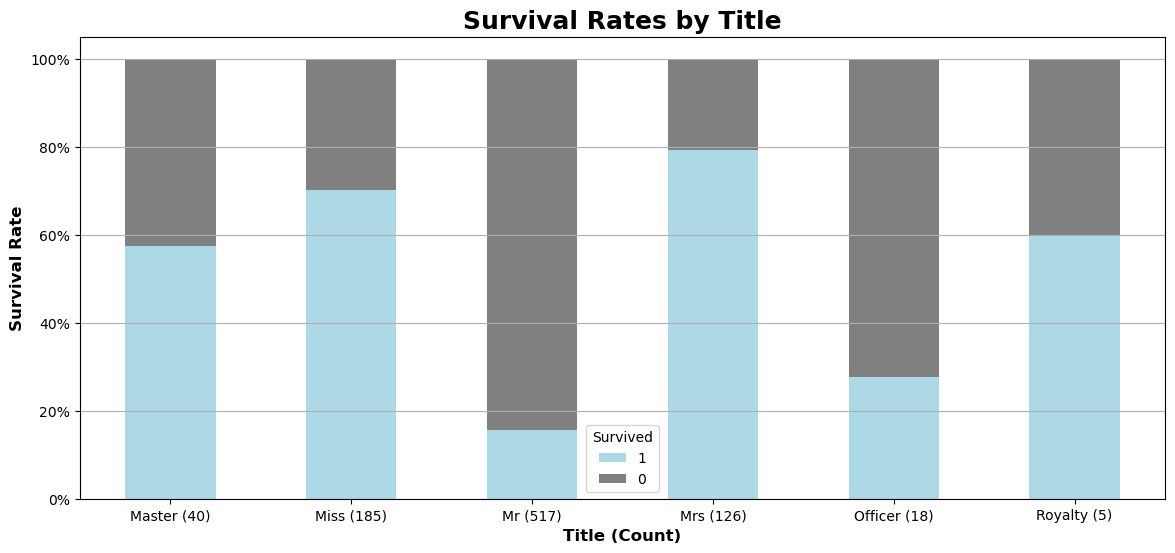

In [12]:
# title_dict = {'Capt': 'Rare',
#               'Col': 'Rare',
#               'Countess': 'Rare',
#               'Don': 'Rare',
#               'Dona': 'Rare',
#               'Dr': 'Officer',
#               'Jonkheer': 'Rare',
#               'Lady': 'Rare',
#               'Major': 'Rare',
#               'Master' : 'Master',
#               'Miss' : 'Miss',
#               'Mlle': 'Miss',
#               'Mme': 'Mrs',
#               'Mr' : 'Mr',
#               'Mrs' : 'Mrs',
#               'Ms': 'Miss',
#               'Rev': 'Officer',
#               'Sir' : 'Rare'}
# rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Major', 'Sir', 'Jonkheer', 'Dona']

# for df in df_list:
#     df['Title'] = df['Title'].replace(rare_titles, 'Rare')
#     df['Title'] = df['Title'].replace('Mlle', 'Miss')
#     df['Title'] = df['Title'].replace('Ms', 'Miss')
#     df['Title'] = df['Title'].replace('Mme', 'Mrs')

# surv_percent_fun('Title', (14, 6))
# train_df.head()

title_dict = {'Capt': 'Officer', 
              'Col': 'Officer',
              'Countess': 'Royalty',
              'Don': 'Royalty',
              'Dona': 'Royalty',
              'Dr': 'Officer',
              'Jonkheer': 'Royalty',
              'Lady': 'Royalty',
              'Major': 'Officer',
              'Master' : 'Master',
              'Miss' : 'Miss',
              'Mlle': 'Miss',
              'Mme': 'Mrs',
              'Mr' : 'Mr',
              'Mrs' : 'Mrs',
              'Ms': 'Miss',
              'Rev': 'Officer',
              'Sir' : 'Royalty'}

for df in df_list:
    for d in title_dict:
        df.loc[df['Title'] == d, 'Title'] = title_dict[d]

surv_percent_fun('Title', (14, 6))
train_df.head()

In [13]:
for p, d in zip(plot_list, df_list):
    p['Title'] = d.copy()['Title']

train_df = pd.get_dummies(train_df, columns = ['Title'], drop_first = False)
test_df = pd.get_dummies(test_df, columns = ['Title'], drop_first = False)
df_list = [train_df, test_df]

for df in df_list:
    for c in [c for c in df.columns if 'Title' in c]:
        df[c] = df[c].astype(int)

train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Ticket_SC,Ticket_SO,Ticket_Soton,Ticket_W,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,...,0,0,0,0,0,0,1,0,0,0
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,...,0,0,0,0,0,0,0,1,0,0
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,...,0,0,1,0,0,1,0,0,0,0
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,...,0,0,0,0,0,0,0,1,0,0
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,...,0,0,0,0,0,0,1,0,0,0


# 2.3. Sex
1. One hot encode sex

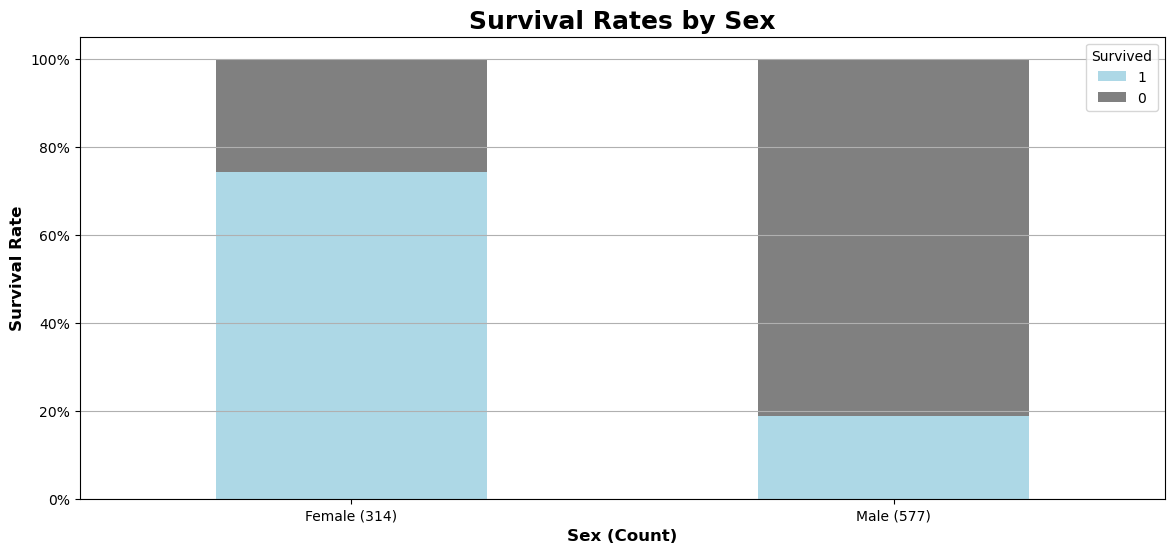

In [14]:
for df in df_list:
    df['Sex'] = df['Sex'].str.title().astype(str)

surv_percent_fun('Sex', (14, 6))

In [15]:
for p, d in zip(plot_list, df_list):
    p['Sex'] = d.copy()['Sex']

train_df = pd.get_dummies(train_df, columns = ['Sex'], drop_first = False)
test_df = pd.get_dummies(test_df, columns = ['Sex'], drop_first = False)
df_list = [train_df, test_df]

for df in df_list:
    for c in [c for c in df.columns if 'Sex' in c]:
        df[c] = df[c].astype(int)

train_df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,...,Ticket_Soton,Ticket_W,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Sex_Female,Sex_Male
0,1,0,3,22.0,1,0,A/5 21171,7.2500,NaN,S,...,0,0,0,0,1,0,0,0,0,1
1,2,1,1,38.0,1,0,PC 17599,71.2833,C85,C,...,0,0,0,0,0,1,0,0,1,0
2,3,1,3,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,...,1,0,0,1,0,0,0,0,1,0
3,4,1,1,35.0,1,0,113803,53.1000,C123,S,...,0,0,0,0,0,1,0,0,1,0
4,5,0,3,35.0,0,0,373450,8.0500,NaN,S,...,0,0,0,0,1,0,0,0,0,1


# 2.4. Port of Embarkation
1. Impute missing with most frequent
2. Add Missing Port Indicator
3. One hot encode Embarked

Most frequent port is S


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,...,Ticket_W,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Sex_Female,Sex_Male,Embarked_Missing
0,1,0,3,22.0,1,0,A/5 21171,7.2500,NaN,S,...,0,0,0,1,0,0,0,0,1,0
1,2,1,1,38.0,1,0,PC 17599,71.2833,C85,C,...,0,0,0,0,1,0,0,1,0,0
2,3,1,3,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,...,0,0,1,0,0,0,0,1,0,0
3,4,1,1,35.0,1,0,113803,53.1000,C123,S,...,0,0,0,0,1,0,0,1,0,0
4,5,0,3,35.0,0,0,373450,8.0500,NaN,S,...,0,0,0,1,0,0,0,0,1,0


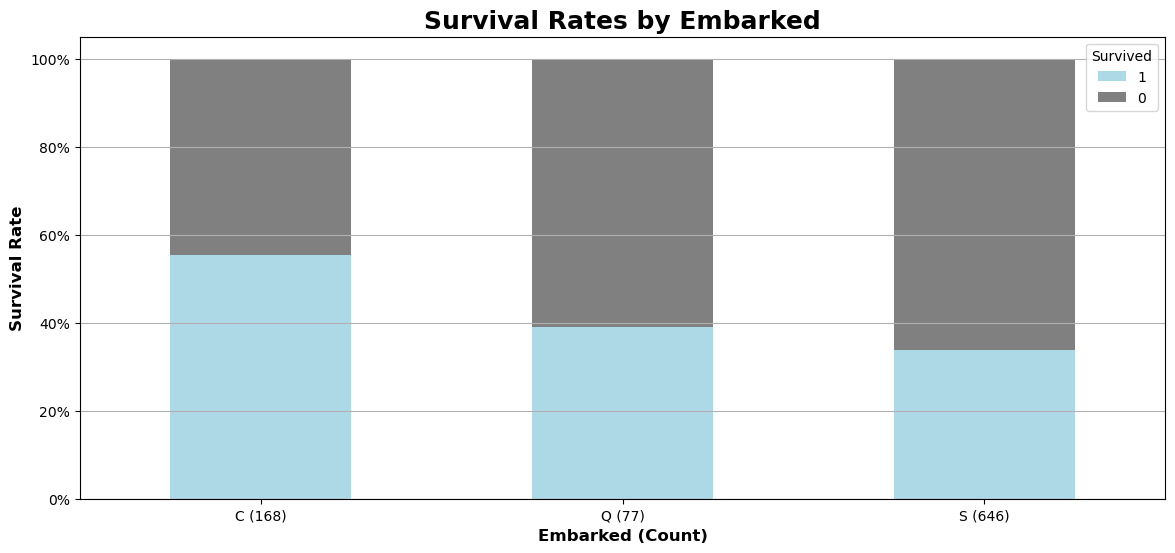

In [16]:
freq_port = train_df.Embarked.dropna().mode()[0]
print('Most frequent port is ' + freq_port)

for df in df_list:
    df.loc[df['Embarked'].isnull(), 'Embarked_Missing'] = 1
    df['Embarked_Missing'] = df['Embarked_Missing'].fillna(0).astype(int)
    df['Embarked'] = df['Embarked'].fillna(freq_port)

surv_percent_fun('Embarked', (14, 6))
train_df.head()

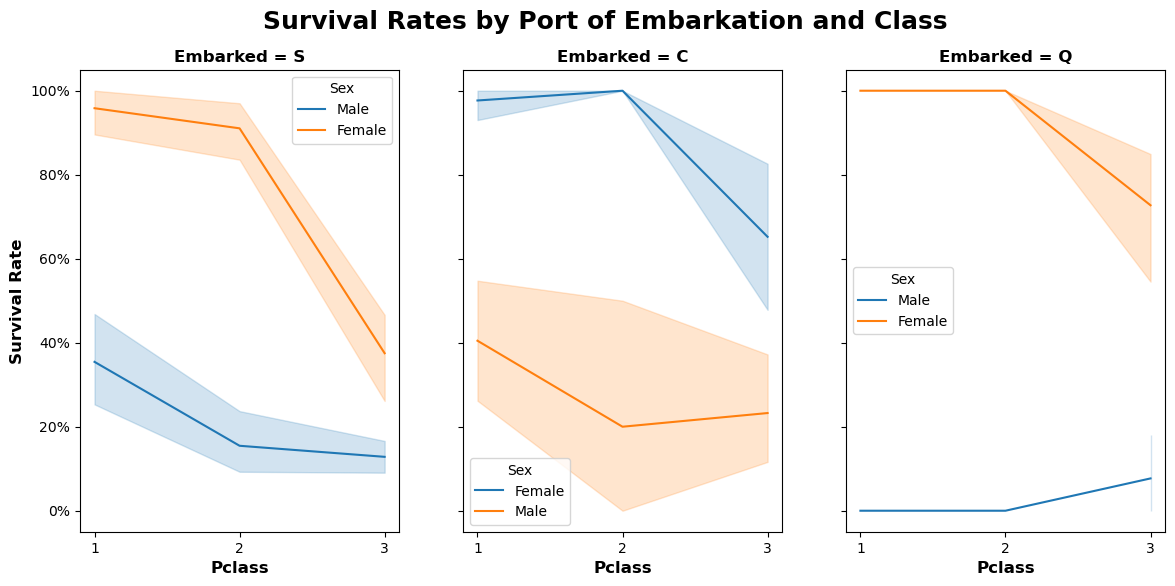

In [17]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, figsize = (14, 6))

for poe, ax in zip(['S', 'C', 'Q'], [ax1, ax2, ax3]):
    sns.lineplot(x = 'Pclass', y = 'Survived', hue = 'Sex',
                 data = plot_df[plot_df['Embarked'] == poe], ax = ax)
    ax.set_xlabel('Pclass', fontdict = plot_axis_dict)
    ax.set_title("Embarked = " + poe, fontdict = plot_axis_dict)
    ax.locator_params(axis = 'x', nbins = 3)
ax1.set_ylabel('Survival Rate', fontdict = plot_axis_dict)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
plt.suptitle('Survival Rates by Port of Embarkation and Class', 
             fontsize = plot_title_dict['fontsize'],
             fontweight = plot_title_dict['fontweight'])
plt.show()

In [18]:
for p, d in zip(plot_list, df_list):
    p['Embarked'] = d.copy()['Embarked']

train_df = pd.get_dummies(train_df, columns = ['Embarked'], drop_first = False)
test_df = pd.get_dummies(test_df, columns = ['Embarked'], drop_first = False)
df_list = [train_df, test_df]

for df in df_list:
    for c in [c for c in df.columns if 'Embarked' in c]:
        df[c] = df[c].astype(int)

train_df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Ticket_A,...,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Sex_Female,Sex_Male,Embarked_Missing,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,22.0,1,0,A/5 21171,7.2500,NaN,1,...,1,0,0,0,0,1,0,0,0,1
1,2,1,1,38.0,1,0,PC 17599,71.2833,C85,0,...,0,1,0,0,1,0,0,1,0,0
2,3,1,3,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,...,0,0,0,0,1,0,0,0,0,1
3,4,1,1,35.0,1,0,113803,53.1000,C123,0,...,0,1,0,0,1,0,0,0,0,1
4,5,0,3,35.0,0,0,373450,8.0500,NaN,0,...,1,0,0,0,0,1,0,0,0,1


# 3. Correlation Matrix

Decided to wait after hot encoding to better understand how to impute missing features.

Features with missing values:
1. **Age:** Correlated with Class and Titles (Master, Miss, Mr, Mrs, and Rare)
2. **Fare:** Correlated with Class, Port of Embarkation, and Ticket (P)

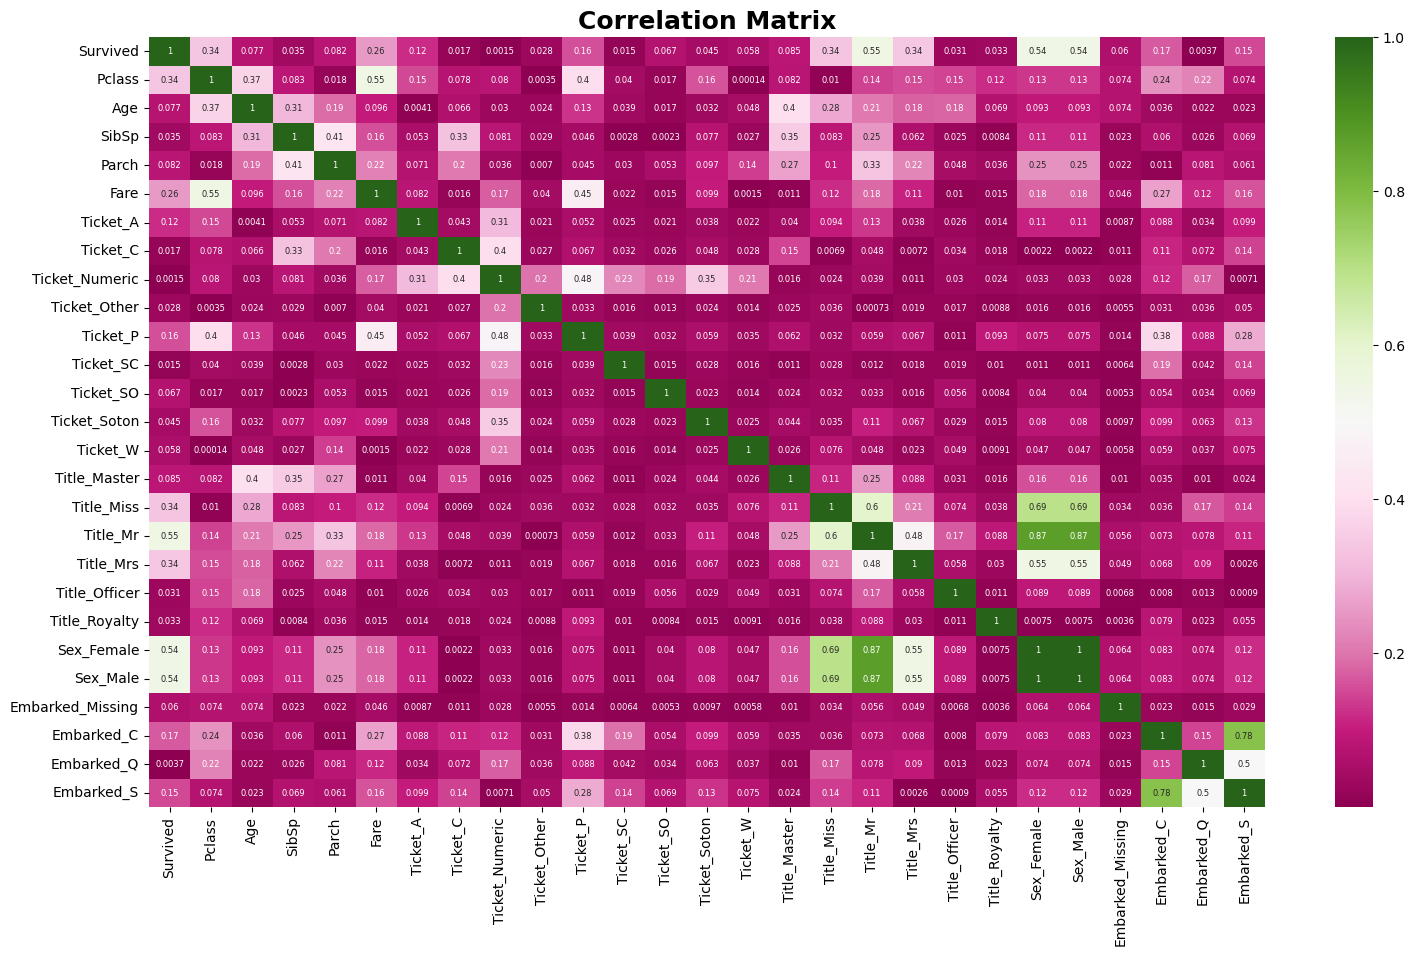

In [19]:
f, ax = plt.subplots(figsize = (18, 10))
corr_df = train_df.drop('PassengerId', axis = 1).corr(numeric_only = True).abs()
sns.heatmap(corr_df, cmap = "PiYG", annot = True, annot_kws = {"fontsize": 6})
plt.title('Correlation Matrix', fontdict = plot_title_dict)
plt.show()

# 4. Feature Engineering, Impute, Bin Features

# 4.1 Age
1. Correlated with Class and Titles (Master, Miss, Mr, Mrs, and Rare)
2. Impute based on correlation
3. Add indicator for missing ages
4. Bin Ages if model perfoms better

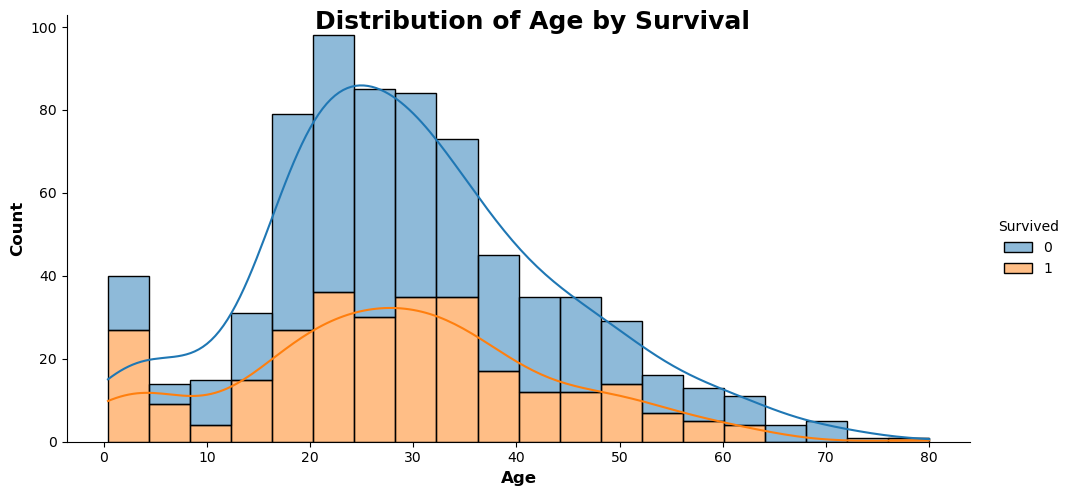

In [20]:
sns.displot(data = train_df, 
            x = 'Age', 
            hue = 'Survived', 
            kde = True,
            height = 5,
            aspect = 2,
            multiple = 'stack')
plt.suptitle('Distribution of Age by Survival',
             fontsize = plot_title_dict['fontsize'],
             fontweight = plot_title_dict['fontweight'])
plt.ylabel('Count', fontdict = plot_axis_dict)
plt.xlabel('Age', fontdict = plot_axis_dict)
plt.show()

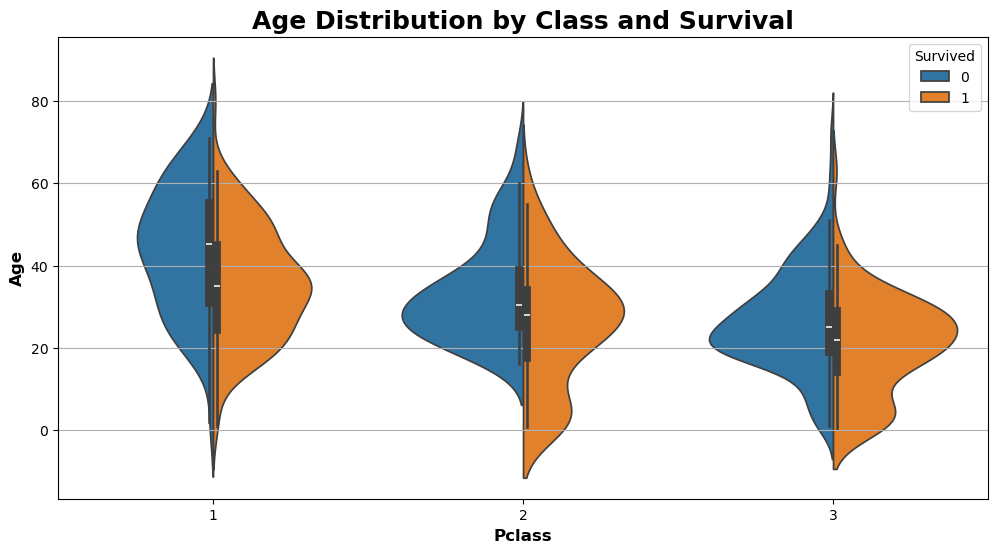

In [21]:
f, ax = plt.subplots(figsize = (12, 6))
sns.violinplot(data = plot_df, x = "Pclass", y = "Age", hue = "Survived", split = True, ax = ax)
ax.set_title('Age Distribution by Class and Survival', fontdict = plot_title_dict)
plt.ylabel('Age', fontdict = plot_axis_dict)
plt.xlabel('Pclass', fontdict = plot_axis_dict)
plt.grid(axis = 'y')
plt.show()

In [22]:
missing_age_cols = ['Pclass', 'Title_Master', 'Title_Mr', 'Title_Mrs', 'Title_Miss', 'Title_Officer']
age_missing_df = train_df[missing_age_cols + ['Age']]\
    .dropna()\
    .groupby(missing_age_cols, as_index = False)\
    .median()
age_missing_df.columns = age_missing_df.columns.str.replace('Age', 'Age_Median')
age_missing_df['Age_Median'] = age_missing_df['Age_Median'].astype(int)

age_missing_df

,Pclass,Title_Master,Title_Mr,Title_Mrs,Title_Miss,Title_Officer,Age_Median
0,1,0,0,0,0,0,40
1,1,0,0,0,0,1,50
2,1,0,0,0,1,0,30
3,1,0,0,1,0,0,40
4,1,0,1,0,0,0,40
5,1,1,0,0,0,0,4
6,2,0,0,0,0,1,46
7,2,0,0,0,1,0,24
8,2,0,0,1,0,0,32
9,2,0,1,0,0,0,31


In [23]:
for df in df_list:
    df.loc[df['Age'].isnull(), 'Age_Missing'] = 1
    df['Age_Missing'] = df['Age_Missing'].fillna(0).astype(int)
    df['Age_Median'] = df.merge(age_missing_df, on = missing_age_cols, how = 'left')['Age_Median']
    df.loc[df['Age'].isnull(), 'Age'] = df['Age_Median']
    df.drop(['Age_Median'], axis = 1, inplace = True)
    df['Age'] = df['Age'].astype(int)

for p, d in zip(plot_list, df_list):
    for c in ['Age', 'Age_Missing']:
        p[c] = d.copy()[c]

train_df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Ticket_A,...,Title_Mrs,Title_Officer,Title_Royalty,Sex_Female,Sex_Male,Embarked_Missing,Embarked_C,Embarked_Q,Embarked_S,Age_Missing
0,1,0,3,22,1,0,A/5 21171,7.2500,NaN,1,...,0,0,0,0,1,0,0,0,1,0
1,2,1,1,38,1,0,PC 17599,71.2833,C85,0,...,1,0,0,1,0,0,1,0,0,0
2,3,1,3,26,0,0,STON/O2. 3101282,7.9250,NaN,0,...,0,0,0,1,0,0,0,0,1,0
3,4,1,1,35,1,0,113803,53.1000,C123,0,...,1,0,0,1,0,0,0,0,1,0
4,5,0,3,35,0,0,373450,8.0500,NaN,0,...,0,0,0,0,1,0,0,0,1,0


In [24]:
# num_bins = 9
# train_df['Age_Interval'] = pd.qcut(train_df['Age'], num_bins)

# age_int_df = train_df\
#     .groupby(['Age_Interval'], as_index = False)\
#     .agg(Survived = ('Survived', 'mean'),
#          Count = ('Age_Interval', 'count'))
# age_int_df['Age'] = range(num_bins)

# fig, axs = plt.subplots(figsize = (22, 9))
# sns.countplot(x = 'Age_Interval', hue = 'Survived', data = train_df)
# plt.title('Distribution of Passengers By Age Interval and Survival')
# plt.show()

# age_int_df

In [25]:
# for df in df_list:
#     df['Age'] = [[b for i, b in zip(age_int_df['Age_Interval'], age_int_df['Age']) if a in i][0] for a in df['Age']]
# train_df.drop(['Age_Interval'], axis = 1, inplace = True)

# train_df.head()

# 4.2. Ticket Composition

This needs to happen after missing age has been imputed.

Cohorts is the number of unique SibSp and Parch combinations within the same ticket and useful to decode whether SibSp refers to a sibling or a spouse and whether Parch refers to a parent or child.

Helpful to substract number of nannies, maids, and chaperones from Pax_Ticket to clasify parents and children.

Max Cohorts in the same ticket is 3.

1. **Nanny:** Refers to nannies, maids, or chaperones. These are passengers traveling with a family but unrelated to them.
2. **Single:** Refers to individuals traveling with no other family on board but can share a room with other stangers.
3. **Parent:** Refers to a parent, with or without a spouse, traveling with at least 1 child.
4. **Child:** Refers person, with or without siblings, traveling with at least 1 parent.
5. **Spouse:** Refers to a married couple traveling with no children.
6. **Sibling:** Refers a person traveling with a sibling, without or children. A parent can also travel with a sibling but is not considered a sibling.

In [26]:
ticket_df = pd.concat([plot_list[0][['PassengerId', 'Ticket', 'Name', 'Sex', 'Age', 'SibSp', 'Parch']],
                       plot_list[1][['PassengerId', 'Ticket', 'Name', 'Sex', 'Age', 'SibSp', 'Parch']]])\
    .reset_index(drop = True)
ticket_df['Ticket'] = ticket_df['Ticket'].str.replace('.', '').str.replace('/', '').str.replace(' ', '')

# Calculate Pax Per Ticket
ticket_freq_df = ticket_df\
    .groupby(['Ticket'], as_index = False)\
    .agg(Pax_Ticket = ('Ticket', 'count'))\
    .sort_values(by = 'Pax_Ticket', ascending = False)

# Calculate Number of Cohorts
ticket_cohorts_df = ticket_df\
    [['Ticket', 'SibSp', 'Parch']]\
    .drop_duplicates()\
    .groupby(['Ticket'], as_index = False)\
    .agg(Cohorts = ('Ticket', 'count'))
print(ticket_cohorts_df['Cohorts'].value_counts())

# Number of Nannies Per Ticket
nanny_df = ticket_df\
    .merge(ticket_cohorts_df, on = ['Ticket'], how = 'left')\
    .query("SibSp == 0 & Parch == 0 & Cohorts >= 2")
ticket_nannies_df = nanny_df\
    .groupby(['Ticket'], as_index = False)\
    .agg(Nannies = ('Ticket', 'count'))

# Combine
ticket_df = ticket_df\
    .merge(ticket_freq_df, on = ['Ticket'], how = 'left')\
    .merge(ticket_cohorts_df, on = ['Ticket'], how = 'left')\
    .merge(ticket_nannies_df, on = ['Ticket'], how = 'left')\
    .sort_values(by = ['Cohorts', 'Pax_Ticket', 'Ticket', 'Parch'], ascending = [False, False, True, False])\
    .reset_index(drop = True)
ticket_df['Nannies'] = ticket_df['Nannies'].fillna(0).astype(int)
ticket_df['Pax_Tix_wo_N'] = ticket_df['Pax_Ticket'] - ticket_df['Nannies'] 
total_pax = ticket_df.shape[0]

Cohorts
1    841
2     80
3      8
Name: count, dtype: int64


# 4.2.1. Ticket Group: SibSp = 0, Parch = 0, Cohorts >= 2

All considered nannies, maids, or chaperones.

In [27]:
nanny_df['Tix'] = 'Nanny'
nanny_df = nanny_df[['PassengerId', 'Tix']]
pax_w_group = [i for i in nanny_df['PassengerId']]
ticket_group_df = nanny_df.copy()

print("Nanny: " + f"{(nanny_df.shape[0] / total_pax):.1%}" + ' of passengers')
print(f"{(1 - ticket_group_df.shape[0] / total_pax):.1%}" + ' of passengers missing a ticket group')

ticket_df\
    .merge(ticket_group_df, on = ['PassengerId'], how = 'left')\
    .query("Ticket == 'PC17608'")\
    .sort_values(by = ['Age'], ascending = [False])

Nanny: 3.2% of passengers
96.8% of passengers missing a ticket group


,PassengerId,Ticket,Name,Sex,Age,SibSp,Parch,Pax_Ticket,Cohorts,Nannies,Pax_Tix_wo_N,Tix
8,1034,PC17608,"Ryerson, Mr. Arthur Larned",Male,61,1,3,7,3,2,5,NaN
7,916,PC17608,"Ryerson, Mrs. Arthur Larned (Emily Maria Borie)",Female,48,1,3,7,3,2,5,NaN
13,1267,PC17608,"Bowen, Miss. Grace Scott",Female,45,0,0,7,3,2,5,Nanny
12,951,PC17608,"Chaudanson, Miss. Victorine",Female,36,0,0,7,3,2,5,Nanny
10,743,PC17608,"Ryerson, Miss. Susan Parker ""Suzette""",Female,21,2,2,7,3,2,5,NaN
9,312,PC17608,"Ryerson, Miss. Emily Borie",Female,18,2,2,7,3,2,5,NaN
11,956,PC17608,"Ryerson, Master. John Borie",Male,13,2,2,7,3,2,5,NaN


# 4.2.2. SibSp = 0, Parch = 0, Cohorts = 1

All considered single individuals traveling alone.

In [28]:
ticket_group_df = nanny_df.copy()

single_df = ticket_df[ticket_df['PassengerId'].isin(ticket_group_df['PassengerId']) == False]\
    .query("SibSp == 0 & Parch == 0 & Cohorts == 1")\
    [['PassengerId']].reset_index(drop = True)
single_df['Tix'] = 'Single'
ticket_group_df = pd.concat([nanny_df, single_df]).reset_index(drop = True)

print("Single: " + f"{(single_df.shape[0] / ticket_df.shape[0]):.1%}" + ' of passengers')
print(f"{(1 - ticket_group_df.shape[0] / total_pax):.1%}" + ' of passengers missing a ticket group')

Single: 57.1% of passengers
39.6% of passengers missing a ticket group


# 4.2.3. SibSp = 1, Parch = 2, Pax_Tix_wo_N = 4

Assumed to two parents traveling with and two children. Two oldest are the parents.

In [29]:
ticket_group_df = pd.concat([nanny_df, single_df]).reset_index(drop = True)

tix_4pax_df = ticket_df[ticket_df['PassengerId'].isin(ticket_group_df['PassengerId']) == False]\
    .query("SibSp == 1 & Parch == 2 & Pax_Tix_wo_N == 4")\
    .sort_values(by = ['Ticket', 'Age'], ascending = [False, True])

tix_4pax_df['Age_Rank'] = tix_4pax_df.groupby(['Ticket']).cumcount()+1
tix_4pax_df.loc[tix_4pax_df['Age_Rank'] <= 2, 'Tix'] = 'Child'
tix_4pax_df['Tix'] = tix_4pax_df['Tix'].fillna('Parent')
tix_4pax_df = tix_4pax_df[['PassengerId', 'Tix']]
ticket_group_df = pd.concat([nanny_df, single_df, tix_4pax_df]).reset_index(drop = True)

print("Child: " + f"{(tix_4pax_df[tix_4pax_df['Tix'] == 'Child'].shape[0] / ticket_df.shape[0]):.1%}" + ' of passengers')
print("Parent: " + f"{(tix_4pax_df[tix_4pax_df['Tix'] == 'Parent'].shape[0] / ticket_df.shape[0]):.1%}" + ' of passengers')
print(f"{(1 - ticket_group_df.shape[0] / total_pax):.1%}" + ' of passengers missing a ticket group')

for t in ['113781', '220845', 'SCParis2123']:
    display(ticket_df\
        .merge(ticket_group_df, on = ['PassengerId'], how = 'left')\
        .query("Ticket == '" + t + "'")\
        .sort_values(by = ['Age'], ascending = [False])\
        [['PassengerId', 'Ticket', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Pax_Tix_wo_N', 'Nannies', 'Tix']])

Child: 1.1% of passengers
Parent: 1.1% of passengers
37.5% of passengers missing a ticket group


,PassengerId,Ticket,Name,Sex,Age,SibSp,Parch,Pax_Tix_wo_N,Nannies,Tix
84,1033,113781,"Daniels, Miss. Sarah",Female,33,0,0,4,2,Nanny
82,1198,113781,"Allison, Mr. Hudson Joshua Creighton",Male,30,1,2,4,2,Parent
81,499,113781,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",Female,25,1,2,4,2,Parent
83,709,113781,"Cleaver, Miss. Alice",Female,22,0,0,4,2,Nanny
79,298,113781,"Allison, Miss. Helen Loraine",Female,2,1,2,4,2,Child
80,306,113781,"Allison, Master. Hudson Trevor",Male,0,1,2,4,2,Child


,PassengerId,Ticket,Name,Sex,Age,SibSp,Parch,Pax_Tix_wo_N,Nannies,Tix
105,1245,220845,"Herman, Mr. Samuel",Male,49,1,2,4,1,Parent
104,755,220845,"Herman, Mrs. Samuel (Jane Laver)",Female,48,1,2,4,1,Parent
103,616,220845,"Herman, Miss. Alice",Female,24,1,2,4,1,Child
106,1277,220845,"Herman, Miss. Kate",Female,24,1,2,4,1,Child
107,1122,220845,"Sweet, Mr. George Frederick",Male,14,0,0,4,1,Nanny


,PassengerId,Ticket,Name,Sex,Age,SibSp,Parch,Pax_Tix_wo_N,Nannies,Tix
345,686,SCParis2123,"Laroche, Mr. Joseph Philippe Lemercier",Male,25,1,2,4,0,Parent
344,609,SCParis2123,"Laroche, Mrs. Joseph (Juliette Marie Louise La...",Female,22,1,2,4,0,Parent
343,44,SCParis2123,"Laroche, Miss. Simonne Marie Anne Andree",Female,3,1,2,4,0,Child
346,1188,SCParis2123,"Laroche, Miss. Louise",Female,1,1,2,4,0,Child


# 4.2.4. Cohorts = 3, with nanny on ticket.

The youngest cohorts assumed to be the children and the remaining cohorts the parents.

In [30]:
ticket_group_df = pd.concat([nanny_df, single_df, tix_4pax_df]).reset_index(drop = True)

cohort_3_wn_df = ticket_df[(ticket_df['PassengerId'].isin(ticket_group_df['PassengerId']) == False) &
    (ticket_df['Ticket'].isin(ticket_nannies_df['Ticket']))]\
    .query("Cohorts == 3")\
    .groupby(['Ticket', 'SibSp', 'Parch'], as_index = False)\
    .agg(Age = ('Age', 'mean'))\
    .sort_values(by = ['Ticket', 'Age'], ascending = [False, True])
cohort_3_wn_df['Age_Rank'] = cohort_3_wn_df.groupby(['Ticket']).cumcount()+1
cohort_3_wn_df.loc[cohort_3_wn_df['Age_Rank'] == 1, 'Tix'] = 'Child'
cohort_3_wn_df['Tix'] = cohort_3_wn_df['Tix'].fillna('Parent')
cohort_3_wn_df = cohort_3_wn_df[['Ticket', 'SibSp', 'Parch', 'Tix']]

cohort_3_wn_df = ticket_df[ticket_df['PassengerId'].isin(ticket_group_df['PassengerId']) == False]\
    [['PassengerId', 'Ticket', 'SibSp', 'Parch']]\
    .merge(cohort_3_wn_df, on = ['Ticket', 'SibSp', 'Parch'], how = 'inner')\
    [['PassengerId', 'Tix']]\
    .reset_index(drop = True)
ticket_group_df = pd.concat([nanny_df, single_df, tix_4pax_df, cohort_3_wn_df]).reset_index(drop = True)

print("Child: " + f"{(cohort_3_wn_df[cohort_3_wn_df['Tix'] == 'Child'].shape[0] / ticket_df.shape[0]):.1%}" + ' of passengers')
print("Parent: " + f"{(cohort_3_wn_df[cohort_3_wn_df['Tix'] == 'Parent'].shape[0] / ticket_df.shape[0]):.1%}" + ' of passengers')
print(f"{(1 - ticket_group_df.shape[0] / total_pax):.1%}" + ' of passengers missing a ticket group')

for t in ['3101295', 'PC17608', '113503']:
    display(ticket_df\
        .merge(ticket_group_df, on = ['PassengerId'], how = 'left')\
        .query("Ticket == '" + t + "'")\
        .sort_values(by = ['Age'], ascending = [False])\
        [['PassengerId', 'Ticket', 'Name', 'Sex', 'Age', 'SibSp', 
          'Parch', 'Cohorts', 'Nannies', 'Tix']])

Child: 1.1% of passengers
Parent: 0.9% of passengers
35.5% of passengers missing a ticket group


,PassengerId,Ticket,Name,Sex,Age,SibSp,Parch,Cohorts,Nannies,Tix
0,639,3101295,"Panula, Mrs. Juha (Maria Emilia Ojala)",Female,41,0,5,3,1,Parent
6,1259,3101295,"Riihivouri, Miss. Susanna Juhantytar Sanni""""",Female,22,0,0,3,1,Nanny
3,267,3101295,"Panula, Mr. Ernesti Arvid",Male,16,4,1,3,1,Child
4,687,3101295,"Panula, Mr. Jaako Arnold",Male,14,4,1,3,1,Child
1,51,3101295,"Panula, Master. Juha Niilo",Male,7,4,1,3,1,Child
5,825,3101295,"Panula, Master. Urho Abraham",Male,2,4,1,3,1,Child
2,165,3101295,"Panula, Master. Eino Viljami",Male,1,4,1,3,1,Child


,PassengerId,Ticket,Name,Sex,Age,SibSp,Parch,Cohorts,Nannies,Tix
8,1034,PC17608,"Ryerson, Mr. Arthur Larned",Male,61,1,3,3,2,Parent
7,916,PC17608,"Ryerson, Mrs. Arthur Larned (Emily Maria Borie)",Female,48,1,3,3,2,Parent
13,1267,PC17608,"Bowen, Miss. Grace Scott",Female,45,0,0,3,2,Nanny
12,951,PC17608,"Chaudanson, Miss. Victorine",Female,36,0,0,3,2,Nanny
10,743,PC17608,"Ryerson, Miss. Susan Parker ""Suzette""",Female,21,2,2,3,2,Child
9,312,PC17608,"Ryerson, Miss. Emily Borie",Female,18,2,2,3,2,Child
11,956,PC17608,"Ryerson, Master. John Borie",Male,13,2,2,3,2,Child


,PassengerId,Ticket,Name,Sex,Age,SibSp,Parch,Cohorts,Nannies,Tix
15,1110,113503,"Widener, Mrs. George Dunton (Eleanor Elkins)",Female,50,1,1,3,2,Parent
16,1299,113503,"Widener, Mr. George Dunton",Male,50,1,1,3,2,Parent
17,966,113503,"Geiger, Miss. Amalie",Female,35,0,0,3,2,Nanny
18,967,113503,"Keeping, Mr. Edwin",Male,32,0,0,3,2,Nanny
14,378,113503,"Widener, Mr. Harry Elkins",Male,27,0,2,3,2,Child


# 4.2.5. Ticket Group: Kink-Heilmann Family
Only 1 ticket left with 3 cohorts, and no nannies. Upon closer inspection, we notice it is the Kink family, with Mr. Anton Kink-Heilmann traveling with his wife and daughter in one cabin, and two siblings on a separate cabin. Map this cabin manually.

In [31]:
ticket_group_df = pd.concat([nanny_df, single_df, tix_4pax_df, cohort_3_wn_df]).reset_index(drop = True)

kink_df = pd.DataFrame({'PassengerId': [1286, 1057, 70, 1268, 185],
                        'Tix': ['Parent', 'Parent', 'Sibling', 'Sibling', 'Child']})
ticket_group_df = pd.concat([nanny_df, single_df, tix_4pax_df, cohort_3_wn_df, kink_df]).reset_index(drop = True)
print(f"{(1 - ticket_group_df.shape[0] / total_pax):.1%}" + ' of passengers missing a ticket group')

ticket_df[ticket_df['Name'].str.contains('Kink')]\
    .merge(ticket_group_df, on = ['PassengerId'], how = 'left')\
    .sort_values(by = ['Ticket', 'Age'], ascending = [False, False])

35.1% of passengers missing a ticket group


,PassengerId,Ticket,Name,Sex,Age,SibSp,Parch,Pax_Ticket,Cohorts,Nannies,Pax_Tix_wo_N,Tix
2,1286,315153,"Kink-Heilmann, Mr. Anton",Male,29,3,1,3,3,0,3,Parent
1,1057,315153,"Kink-Heilmann, Mrs. Anton (Luise Heilmann)",Female,26,1,1,3,3,0,3,Parent
0,185,315153,"Kink-Heilmann, Miss. Luise Gretchen",Female,4,0,2,3,3,0,3,Child
4,1268,315152,"Kink, Miss. Maria",Female,22,2,0,1,1,0,1,Sibling
3,70,315151,"Kink, Mr. Vincenz",Male,26,2,0,1,1,0,1,Sibling


# 4.2.6. Cohorts = 2, with no nanny on ticket.

In cabins without a nanny and 2 cohorts, the remaining 2 cohorts are assumed to be parent and child. 

The youngest cohort in the ticket assumed to be the children. The older cohort parents.

In [32]:
ticket_group_df = pd.concat([nanny_df, single_df, tix_4pax_df, cohort_3_wn_df, kink_df]).reset_index(drop = True)

cohort_2_nn_df = ticket_df[(ticket_df['PassengerId'].isin(ticket_group_df['PassengerId']) == False) &
    (ticket_df['Ticket'].isin(ticket_nannies_df['Ticket']) == False)]\
    .query("Cohorts == 2")\
    .groupby(['Ticket', 'SibSp', 'Parch'], as_index = False)\
    .agg(Age = ('Age', 'mean'))\
    .sort_values(by = ['Ticket', 'Age'], ascending = [False, True])
cohort_2_nn_df['Age_Rank'] = cohort_2_nn_df.groupby(['Ticket']).cumcount()+1
cohort_2_nn_df.loc[cohort_2_nn_df['Age_Rank'] == 1, 'Tix'] = 'Child'
cohort_2_nn_df['Tix'] = cohort_2_nn_df['Tix'].fillna('Parent')
cohort_2_nn_df = cohort_2_nn_df[['Ticket', 'SibSp', 'Parch', 'Tix']]

cohort_2_nn_df = ticket_df[(ticket_df['PassengerId'].isin(ticket_group_df['PassengerId']) == False) &
    (ticket_df['Ticket'].isin(ticket_nannies_df['Ticket']) == False)]\
    .query("Cohorts == 2")\
    [['PassengerId', 'Ticket', 'SibSp', 'Parch']]\
    .merge(cohort_2_nn_df, on = ['Ticket', 'SibSp', 'Parch'], how = 'inner')\
    [['PassengerId', 'Tix']]\
    .reset_index(drop = True)
ticket_group_df = pd.concat([nanny_df, single_df, tix_4pax_df, cohort_3_wn_df, kink_df, 
                             cohort_2_nn_df]).reset_index(drop = True)

print("Child: " + f"{(cohort_2_nn_df[cohort_2_nn_df['Tix'] == 'Child'].shape[0] / ticket_df.shape[0]):.1%}" + ' of passengers')
print("Parent: " + f"{(cohort_2_nn_df[cohort_2_nn_df['Tix'] == 'Parent'].shape[0] / ticket_df.shape[0]):.1%}" + ' of passengers')
print(f"{(1 - ticket_group_df.shape[0] / total_pax):.1%}" + ' of passengers missing a ticket group')

for t in ['CA2343', 'CA2144']:
    display(ticket_df\
        .merge(ticket_group_df, on = ['PassengerId'], how = 'left')\
        .query("Ticket == '" + t + "'")\
        .sort_values(by = ['Age'], ascending = [False])\
        [['PassengerId', 'Ticket', 'Name', 'Sex', 'Age', 'SibSp', 
          'Parch', 'Cohorts', 'Nannies', 'Tix']])

Child: 9.0% of passengers
Parent: 6.0% of passengers
20.1% of passengers missing a ticket group


,PassengerId,Ticket,Name,Sex,Age,SibSp,Parch,Cohorts,Nannies,Tix
40,1257,CA2343,"Sage, Mrs. John (Annie Bullen)",Female,31,1,9,2,0,Parent
39,1234,CA2343,"Sage, Mr. John George",Male,26,1,9,2,0,Parent
43,202,CA2343,"Sage, Mr. Frederick",Male,26,8,2,2,0,Child
44,325,CA2343,"Sage, Mr. George John Jr",Male,26,8,2,2,0,Child
46,847,CA2343,"Sage, Mr. Douglas Bullen",Male,26,8,2,2,0,Child
42,181,CA2343,"Sage, Miss. Constance Gladys",Female,18,8,2,2,0,Child
45,793,CA2343,"Sage, Miss. Stella Anna",Female,18,8,2,2,0,Child
47,864,CA2343,"Sage, Miss. Dorothy Edith ""Dolly""",Female,18,8,2,2,0,Child
48,1080,CA2343,"Sage, Miss. Ada",Female,18,8,2,2,0,Child
49,1252,CA2343,"Sage, Master. William Henry",Male,14,8,2,2,0,Child


,PassengerId,Ticket,Name,Sex,Age,SibSp,Parch,Cohorts,Nannies,Tix
50,679,CA2144,"Goodwin, Mrs. Frederick (Augusta Tyler)",Female,43,1,6,2,0,Parent
51,1031,CA2144,"Goodwin, Mr. Charles Frederick",Male,40,1,6,2,0,Parent
53,72,CA2144,"Goodwin, Miss. Lillian Amy",Female,16,5,2,2,0,Child
56,684,CA2144,"Goodwin, Mr. Charles Edward",Male,14,5,2,2,0,Child
52,60,CA2144,"Goodwin, Master. William Frederick",Male,11,5,2,2,0,Child
57,1032,CA2144,"Goodwin, Miss. Jessie Allis",Female,10,5,2,2,0,Child
55,481,CA2144,"Goodwin, Master. Harold Victor",Male,9,5,2,2,0,Child
54,387,CA2144,"Goodwin, Master. Sidney Leonard",Male,1,5,2,2,0,Child


# 4.2.7. Cohorts = 2, with nanny on ticket.

Cannot programmatically distinguish between parent and child, or sibling and spouse. Mapped manually.

In [33]:
ticket_group_df = pd.concat([nanny_df, single_df, tix_4pax_df, cohort_3_wn_df, kink_df, 
                             cohort_2_nn_df]).reset_index(drop = True)

cohort_2_df = pd.DataFrame({'PassengerId': [121, 656, 666, 701, 1094, 821, 1200, 690, 780, 973, 
                                            1006, 680, 1235, 880, 1042, 276, 766, 742, 988, 721, 849, 110, 
                                            769, 32, 1208, 53, 646, 269, 333, 308, 506, 545, 1131, 1170, 1298, 
                                            600, 557],
                            'Tix': ['Sibling', 'Sibling', 'Sibling', 'Spouse', 'Spouse', 'Parent', 'Parent', 
                                    'Child', 'Parent', 'Spouse', 'Spouse', 'Child', 'Parent', 'Parent', 'Child', 
                                    'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Child', 'Parent', 'Sibling', 'Sibling', 
                                    'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Parent', 'Child', 'Spouse', 'Spouse', 'Spouse', 
                                    'Spouse', 'Sibling', 'Sibling', 'Spouse', 'Spouse']})

ticket_group_df = pd.concat([nanny_df, single_df, tix_4pax_df, cohort_3_wn_df, kink_df, 
                             cohort_2_nn_df, cohort_2_df]).reset_index(drop = True)
print("Child: " + f"{(cohort_2_df[cohort_2_df['Tix'] == 'Child'].shape[0] / ticket_df.shape[0]):.1%}" + ' of passengers')
print("Parent: " + f"{(cohort_2_df[cohort_2_df['Tix'] == 'Parent'].shape[0] / ticket_df.shape[0]):.1%}" + ' of passengers')
print("Spouse: " + f"{(cohort_2_df[cohort_2_df['Tix'] == 'Spouse'].shape[0] / ticket_df.shape[0]):.1%}" + ' of passengers')
print("Sibling: " + f"{(cohort_2_df[cohort_2_df['Tix'] == 'Sibling'].shape[0] / ticket_df.shape[0]):.1%}" + ' of passengers')
print(f"{(1 - ticket_group_df.shape[0] / total_pax):.1%}" + ' of passengers missing a ticket group')

for t in ['371110', 'PC17757']:
    display(ticket_df\
        .merge(ticket_group_df, on = ['PassengerId'], how = 'left')\
        .query("Ticket == '" + t + "'")\
        .sort_values(by = ['Age'], ascending = [False])\
        [['PassengerId', 'Ticket', 'Name', 'Sex', 'Age', 'SibSp', 
          'Parch', 'Cohorts', 'Nannies', 'Tix']])

Child: 0.4% of passengers
Parent: 0.5% of passengers
Spouse: 1.4% of passengers
Sibling: 0.5% of passengers
17.3% of passengers missing a ticket group


,PassengerId,Ticket,Name,Sex,Age,SibSp,Parch,Cohorts,Nannies,Tix
228,518,371110,"Ryan, Mr. Patrick",Male,26,0,0,2,1,Nanny
229,769,371110,"Moran, Mr. Daniel J",Male,26,1,0,2,1,Sibling
227,110,371110,"Moran, Miss. Bertha",Female,18,1,0,2,1,Sibling


,PassengerId,Ticket,Name,Sex,Age,SibSp,Parch,Cohorts,Nannies,Tix
122,1094,PC17757,"Astor, Col. John Jacob",Male,47,1,0,2,3,Spouse
118,381,PC17757,"Bidois, Miss. Rosalie",Female,42,0,0,2,3,Nanny
119,558,PC17757,"Robbins, Mr. Victor",Male,40,0,0,2,3,Nanny
121,717,PC17757,"Endres, Miss. Caroline Louise",Female,38,0,0,2,3,Nanny
120,701,PC17757,"Astor, Mrs. John Jacob (Madeleine Talmadge Force)",Female,18,1,0,2,3,Spouse


# 4.2.8. Cohorts = 2, Pax_Ticket = 2, SibSp = 1, Parch = 0

Cannot programmatically distinguish between a spouse couple, or sibling couple. Mapped manually.

In [34]:
ticket_group_df = pd.concat([nanny_df, single_df, tix_4pax_df, cohort_3_wn_df, kink_df, 
                             cohort_2_nn_df, cohort_2_df]).reset_index(drop = True)

siblings_df = pd.DataFrame({'PassengerId': [367, 1128, 749, 1074, 152, 337, 36, 384, 4, 138, 725, 810, 
                                            42, 118, 622, 936, 371, 1256, 992, 1069, 292, 485, 926, 1014, 
                                            435, 578, 1144, 1164, 942, 1287, 454, 850, 458, 1137, 691, 782, 
                                            225, 487, 670, 713, 427, 1220, 904, 1179, 519, 1082, 134, 993, 
                                            729, 1167, 10, 123, 905, 1105, 250, 855, 100, 317, 40, 126, 621, 
                                            831, 977, 1141, 112, 241, 237, 1140, 74, 1007, 579, 1258, 406, 
                                            1293, 544, 547, 54, 1169, 560, 1152, 982, 1064, 50, 354, 606, 1251, 
                                            242, 613, 497, 592, 63, 231, 187, 365, 47, 1165, 432, 640, 744, 1275, 
                                            348, 950, 254, 618, 133, 917, 2, 1126, 514, 912, 35, 376, 309, 875, 595, 
                                            1011, 433, 922, 362, 907, 143, 404, 93, 906], 
                            'Tix': ['Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 
                                    'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 
                                    'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 
                                    'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 
                                    'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 
                                    'Spouse', 'Spouse', 'Spouse', 'Sibling', 'Sibling', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 
                                    'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Sibling', 'Sibling', 'Spouse', 'Spouse', 'Spouse', 
                                    'Spouse', 'Sibling', 'Sibling', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 
                                    'Sibling', 'Sibling', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 
                                    'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Sibling', 'Sibling', 'Sibling', 'Sibling', 
                                    'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Sibling', 'Sibling', 'Spouse', 'Spouse', 'Spouse', 
                                    'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 
                                    'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 
                                    'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse', 'Spouse']})
ticket_group_df = pd.concat([nanny_df, single_df, tix_4pax_df, cohort_3_wn_df, kink_df, 
                             cohort_2_nn_df, cohort_2_df, siblings_df]).reset_index(drop = True)
print(f"{(1 - ticket_group_df.shape[0] / total_pax):.1%}" + ' of passengers missing a ticket group')

for t in ['370365', '370371']:
    display(ticket_df\
        .merge(ticket_group_df, on = ['PassengerId'], how = 'left')\
        .query("Ticket == '" + t + "'")\
        .sort_values(by = ['Age'], ascending = [False])\
        [['PassengerId', 'Ticket', 'Name', 'Sex', 'Age', 'SibSp', 
          'Parch', 'Cohorts', 'Nannies', 'Tix']])

7.8% of passengers missing a ticket group


,PassengerId,Ticket,Name,Sex,Age,SibSp,Parch,Cohorts,Nannies,Tix
530,187,370365,"O'Brien, Mrs. Thomas (Johanna ""Hannah"" Godfrey)",Female,31,1,0,1,0,Spouse
531,365,370365,"O'Brien, Mr. Thomas",Male,26,1,0,1,0,Spouse


,PassengerId,Ticket,Name,Sex,Age,SibSp,Parch,Cohorts,Nannies,Tix
532,47,370371,"Lennon, Mr. Denis",Male,26,1,0,1,0,Sibling
533,1165,370371,"Lennon, Miss. Mary",Female,18,1,0,1,0,Sibling


# 4.2.9. Cohorts = 1, Pax_Ticket = 2, SibSp = 0, Parch = 1

Youngest person considered the child. Oldest parent.

In [35]:
ticket_group_df = pd.concat([nanny_df, single_df, tix_4pax_df, cohort_3_wn_df, kink_df, 
                             cohort_2_nn_df, cohort_2_df, siblings_df]).reset_index(drop = True)

parch_df = ticket_df[(ticket_df['PassengerId'].isin(ticket_group_df['PassengerId']) == False)]\
    .query("Cohorts == 1 & Pax_Ticket == 2 & Parch == 1 & SibSp == 0")\
    .sort_values(by = ['Ticket', 'Age'], ascending = [False, True])
parch_df['Age_Rank'] = parch_df.groupby(['Ticket']).cumcount()+1
parch_df.loc[parch_df['Age_Rank'] == 1, 'Tix'] = 'Child'
parch_df['Tix'] = parch_df['Tix'].fillna('Parent')
parch_df = parch_df[['PassengerId', 'Tix']]

ticket_group_df = pd.concat([nanny_df, single_df, tix_4pax_df, cohort_3_wn_df, kink_df, 
                             cohort_2_nn_df, cohort_2_df, siblings_df, parch_df]).reset_index(drop = True)
print(f"{(1 - ticket_group_df.shape[0] / total_pax):.1%}" + ' of passengers missing a ticket group')

for t in ['113505', '112378']:
    display(ticket_df\
        .merge(ticket_group_df, on = ['PassengerId'], how = 'left')\
        .query("Ticket == '" + t + "'")\
        .sort_values(by = ['Age'], ascending = [False])\
        [['PassengerId', 'Ticket', 'Name', 'Sex', 'Age', 'SibSp', 
          'Parch', 'Cohorts', 'Nannies', 'Pax_Ticket', 'Tix']])

5.2% of passengers missing a ticket group


,PassengerId,Ticket,Name,Sex,Age,SibSp,Parch,Cohorts,Nannies,Pax_Ticket,Tix
378,167,113505,"Chibnall, Mrs. (Edith Martha Bowerman)",Female,40,0,1,1,0,2,Parent
379,357,113505,"Bowerman, Miss. Elsie Edith",Female,22,0,1,1,0,2,Child


,PassengerId,Ticket,Name,Sex,Age,SibSp,Parch,Cohorts,Nannies,Pax_Ticket,Tix
374,1260,112378,"Gibson, Mrs. Leonard (Pauline C Boeson)",Female,45,0,1,1,0,2,Parent
375,1294,112378,"Gibson, Miss. Dorothy Winifred",Female,22,0,1,1,0,2,Child


# 4.2.10. Ticket Group: Cohorts = 1 (Remaining)

Cannot programmatically distinguish. Mapped manually. 

Some multi-family relationships tricky if pax has both a parent and a child like the Hocking Family

In [36]:
cohort_1_df = pd.DataFrame({'PassengerId': [566, 901, 1079, 49, 921, 1189, 302, 331, 1019, 249, 872, 137, 588, 
                                            1289, 540, 313, 1041, 418, 189, 658, 594, 1229, 533, 353, 452, 491, 
                                            1112, 867, 910, 730, 1262, 862, 1013, 215, 114, 403, 1124, 372, 1, 
                                            478, 572, 1248, 969, 198, 913, 176, 335, 661, 1296, 665, 193, 722, 
                                            19, 1037, 39, 334, 1197, 714, 41, 775, 530, 944, 438, 893, 408, 832, 
                                            105, 393, 1025, 1130, 274, 443, 268, 1106, 705, 69, 1211, 923],
                            'Tix': ['Sibling', 'Sibling', 'Sibling', 'Sibling', 'Sibling', 'Sibling', 'Sibling', 
                                    'Sibling', 'Sibling', 'Parent', 'Parent', 'Child', 'Parent', 'Parent', 'Child', 
                                    'Parent', 'Parent', 'Child', 'Parent', 'Parent', 'Child', 'Parent', 'Child', 
                                    'Child', 'Sibling', 'Sibling', 'Sibling', 'Sibling', 'Sibling', 'Sibling', 
                                    'Sibling', 'Sibling', 'Sibling', 'Sibling', 'Sibling', 'Sibling', 'Sibling', 
                                    'Sibling', 'Sibling', 'Sibling', 'Sibling', 'Sibling', 'Sibling', 'Parent', 
                                    'Child', 'Child', 'Spouse', 'Spouse', 'Sibling', 'Sibling', 'Sibling', 'Sibling', 
                                    'Spouse', 'Spouse', 'Sibling', 'Sibling', 'Parent', 'Child', 'Parent', 'Parent', 
                                    'Child', 'Child', 'Parent', 'Sibling', 'Child', 'Child', 'Sibling', 'Sibling', 
                                    'Spouse', 'Spouse', 'Parent', 'Sibling', 'Sibling', 'Parent', 'Sibling', 'Parent', 
                                    'Sibling', 'Sibling']})

ticket_group_df = pd.concat([nanny_df, single_df, tix_4pax_df, cohort_3_wn_df, kink_df, 
                             cohort_2_nn_df, cohort_2_df, siblings_df, parch_df]).reset_index(drop = True)
ticket_group_df = ticket_group_df[ticket_group_df['PassengerId'].isin(cohort_1_df['PassengerId']) == False].reset_index(drop = True)

ticket_group_df = pd.concat([ticket_group_df, cohort_1_df]).reset_index(drop = True)
print(f"{(total_pax - ticket_group_df.shape[0]):,}" + ' of passengers missing a ticket group')

# Append to data
for df in df_list:
    df['Tix'] = df.merge(ticket_group_df, on = ['PassengerId'], how = 'left')['Tix']

train_df.head()

0 of passengers missing a ticket group


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Ticket_A,...,Title_Officer,Title_Royalty,Sex_Female,Sex_Male,Embarked_Missing,Embarked_C,Embarked_Q,Embarked_S,Age_Missing,Tix
0,1,0,3,22,1,0,A/5 21171,7.2500,NaN,1,...,0,0,0,1,0,0,0,1,0,Sibling
1,2,1,1,38,1,0,PC 17599,71.2833,C85,0,...,0,0,1,0,0,1,0,0,0,Spouse
2,3,1,3,26,0,0,STON/O2. 3101282,7.9250,NaN,0,...,0,0,1,0,0,0,0,1,0,Single
3,4,1,1,35,1,0,113803,53.1000,C123,0,...,0,0,1,0,0,0,0,1,0,Spouse
4,5,0,3,35,0,0,373450,8.0500,NaN,0,...,0,0,0,1,0,0,0,1,0,Single


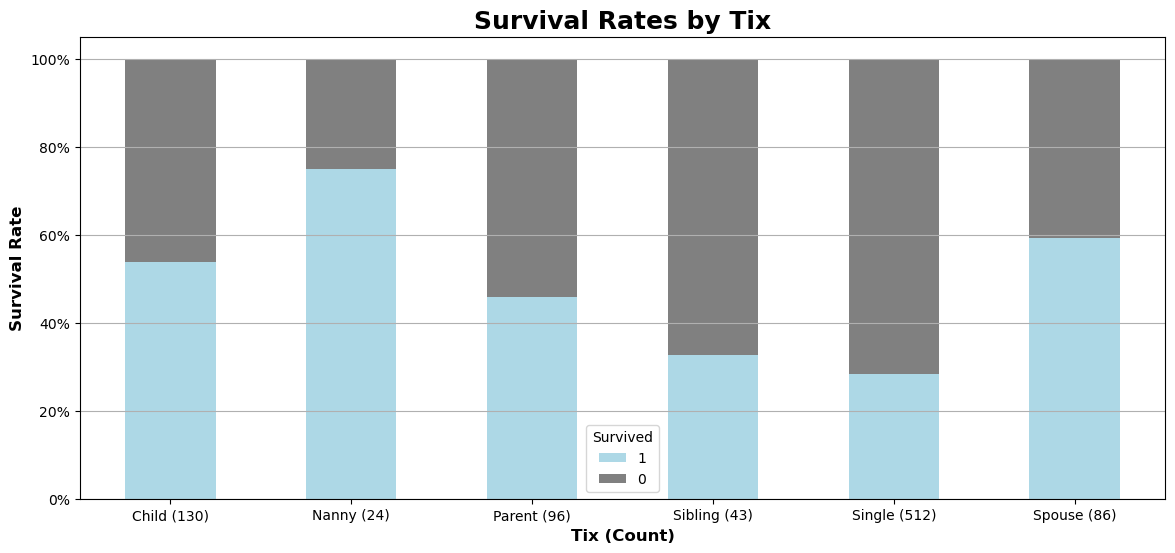

In [37]:
surv_percent_fun('Tix', (14, 6))

In [38]:
for p, d in zip(plot_list, df_list):
    p['Tix'] = d.copy()['Tix']

train_df = pd.get_dummies(train_df, columns = ['Tix'], drop_first = False)
test_df = pd.get_dummies(test_df, columns = ['Tix'], drop_first = False)
df_list = [train_df, test_df]

for df in df_list:
    for c in [c for c in df.columns if 'Tix' in c]:
        df[c] = df[c].astype(int)
    df.drop(['Ticket', 'SibSp', 'Parch'], axis = 1, inplace = True)

train_df.head()

,PassengerId,Survived,Pclass,Age,Fare,Cabin,Ticket_A,Ticket_C,Ticket_Numeric,Ticket_Other,...,Embarked_C,Embarked_Q,Embarked_S,Age_Missing,Tix_Child,Tix_Nanny,Tix_Parent,Tix_Sibling,Tix_Single,Tix_Spouse
0,1,0,3,22,7.2500,NaN,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,2,1,1,38,71.2833,C85,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,3,1,3,26,7.9250,NaN,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,4,1,1,35,53.1000,C123,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
4,5,0,3,35,8.0500,NaN,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0


# 4.3. Family Size

SibSp and Parch not suitable for family size since they combine two different relationships. Use ticket group to calculate relationship count within the same group.

In [39]:
family_df = pd.DataFrame()

for p in ticket_df['PassengerId']:
    pax_id_tix = ticket_df[ticket_df['PassengerId'] == p]['Ticket'].iloc[0]
    
    dummy_df = ticket_df[ticket_df['Ticket'] == pax_id_tix]\
        .merge(ticket_group_df, on = ['PassengerId'], how = 'left')\
        [['Ticket', 'Pax_Ticket', 'Tix']]
    dummy_df['PassengerId'] = p
    dummy_df.loc[dummy_df['Tix'] == 'Parent', 'Num_Parents'] = 1
    dummy_df.loc[dummy_df['Tix'] == 'Spouse', 'Num_Spouse'] = 1
    dummy_df.loc[dummy_df['Tix'] == 'Child', 'Num_Children'] = 1
    dummy_df.loc[dummy_df['Tix'] == 'Sibling', 'Num_Siblings'] = 1
    dummy_df.loc[dummy_df['Tix'] == 'Nanny', 'Num_Nannies'] = 1
    
    for c in ['Num_Parents', 'Num_Spouse', 'Num_Children', 'Num_Siblings', 'Num_Nannies']:
        dummy_df[c] = dummy_df[c].fillna(0).astype(int)
    
    dummy_df = dummy_df\
        .groupby(['PassengerId', 'Pax_Ticket'], as_index = False)\
        .agg(Num_Parents = ('Num_Parents', 'sum'),
             Num_Spouse = ('Num_Spouse', 'sum'),
             Num_Children = ('Num_Children', 'sum'),
             Num_Siblings = ('Num_Siblings', 'sum'),
             Num_Nannies = ('Num_Nannies', 'sum'))
    dummy_df['Num_Family'] = dummy_df['Num_Parents'] + dummy_df['Num_Spouse'] + dummy_df['Num_Children'] +\
        dummy_df['Num_Siblings'] + dummy_df['Num_Nannies']
    family_df = pd.concat([family_df, dummy_df]).reset_index(drop = True)

# Append to data
for df in df_list:
    for c in ['Num_Parents', 'Num_Spouse', 'Num_Children', 'Num_Siblings', 'Num_Nannies', 'Num_Family', 'Pax_Ticket']:
        df[c] = df.merge(family_df, on = ['PassengerId'], how = 'left')[c]

train_df.head()

,PassengerId,Survived,Pclass,Age,Fare,Cabin,Ticket_A,Ticket_C,Ticket_Numeric,Ticket_Other,...,Tix_Sibling,Tix_Single,Tix_Spouse,Num_Parents,Num_Spouse,Num_Children,Num_Siblings,Num_Nannies,Num_Family,Pax_Ticket
0,1,0,3,22,7.2500,NaN,1,0,0,0,...,1,0,0,0,0,0,1,0,1,1
1,2,1,1,38,71.2833,C85,0,0,0,0,...,0,0,1,0,2,0,0,0,2,2
2,3,1,3,26,7.9250,NaN,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,4,1,1,35,53.1000,C123,0,0,1,0,...,0,0,1,0,2,0,0,0,2,2
4,5,0,3,35,8.0500,NaN,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1


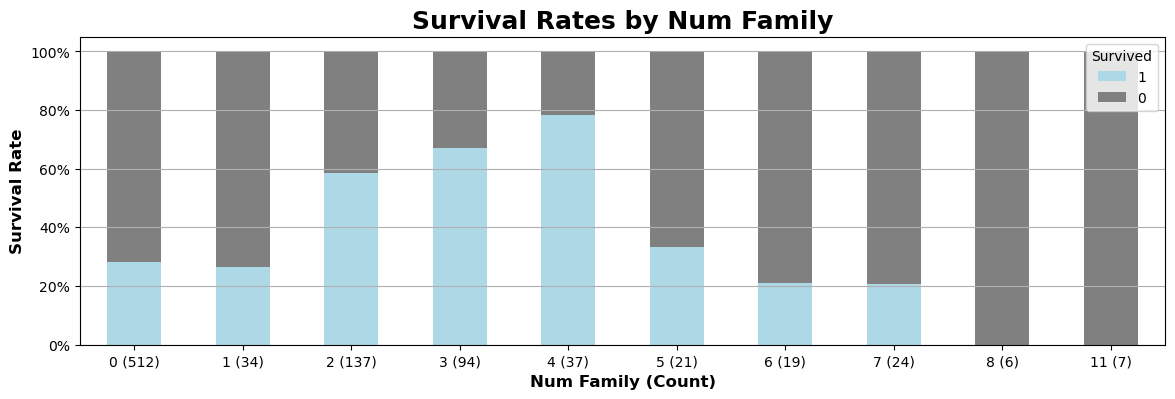

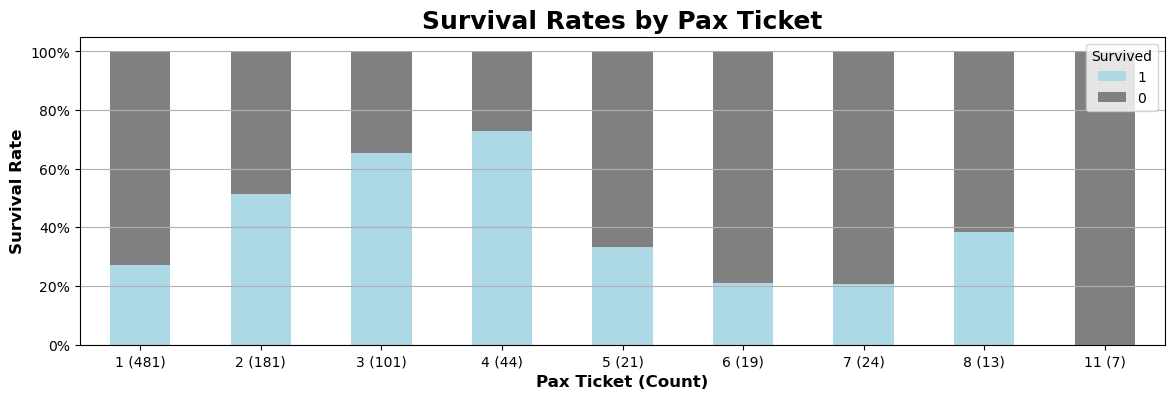

In [40]:
for c in ['Num_Family', 'Pax_Ticket']:
    surv_percent_fun(c, (14, 4))

# 4.4. Passenger Class
1. One hot encode pclass

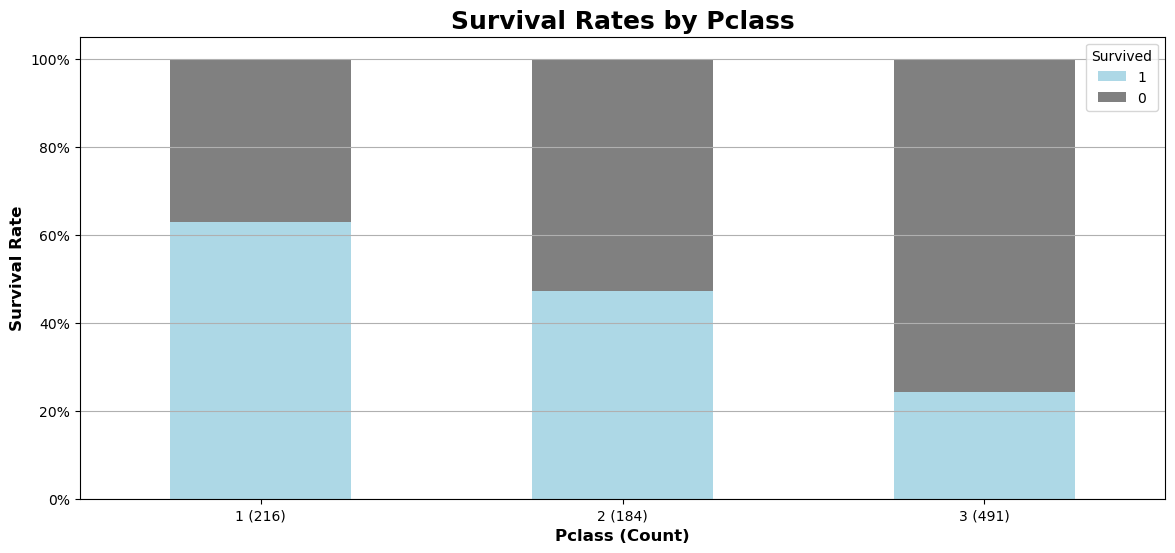

In [41]:
surv_percent_fun('Pclass', (14, 6))

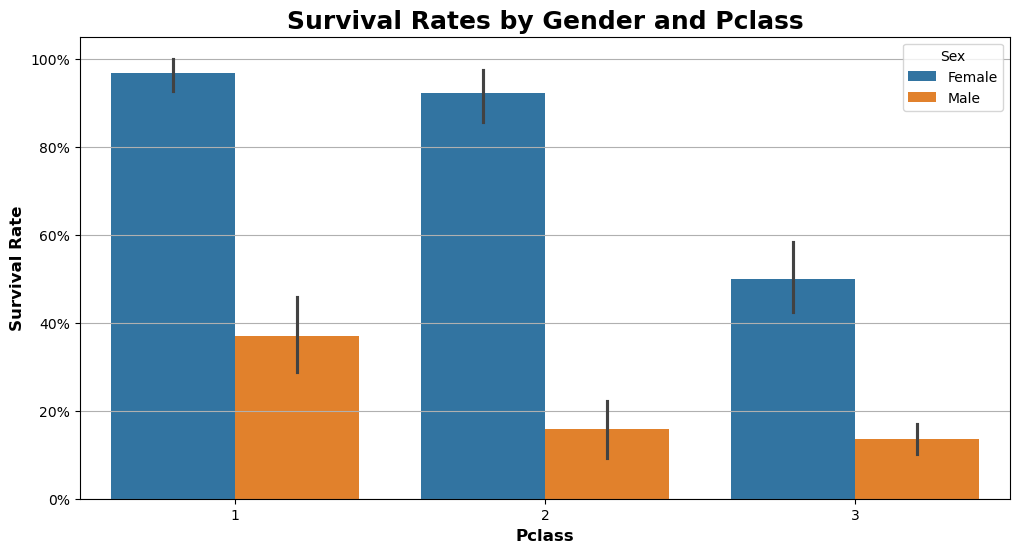

In [42]:
f, ax = plt.subplots(figsize = (12, 6))
sns.barplot(x = 'Pclass', y = 'Survived', hue = 'Sex', data = plot_df)
plt.title('Survival Rates by Gender and Pclass', fontdict = plot_title_dict)
plt.ylabel('Survival Rate', fontdict = plot_axis_dict)
plt.xlabel('Pclass', fontdict = plot_axis_dict)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
plt.grid(axis = 'y')
plt.show()

In [43]:
train_df = pd.get_dummies(train_df, columns = ['Pclass'], drop_first = False)
test_df = pd.get_dummies(test_df, columns = ['Pclass'], drop_first = False)
df_list = [train_df, test_df]

for df in df_list:
    for c in [c for c in df.columns if 'Pclass' in c]:
        df[c] = df[c].astype(int)

train_df.head()

,PassengerId,Survived,Age,Fare,Cabin,Ticket_A,Ticket_C,Ticket_Numeric,Ticket_Other,Ticket_P,...,Num_Parents,Num_Spouse,Num_Children,Num_Siblings,Num_Nannies,Num_Family,Pax_Ticket,Pclass_1,Pclass_2,Pclass_3
0,1,0,22,7.2500,NaN,1,0,0,0,0,...,0,0,0,1,0,1,1,0,0,1
1,2,1,38,71.2833,C85,0,0,0,0,1,...,0,2,0,0,0,2,2,1,0,0
2,3,1,26,7.9250,NaN,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,4,1,35,53.1000,C123,0,0,1,0,0,...,0,2,0,0,0,2,2,1,0,0
4,5,0,35,8.0500,NaN,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


# 4.5. Fare
1. Correlated with Class, Port of Embarkation, and Ticket (P)
2. Impute based on correlation
3. Add indicator for missing fare
4. Bin Fares if model perfoms better

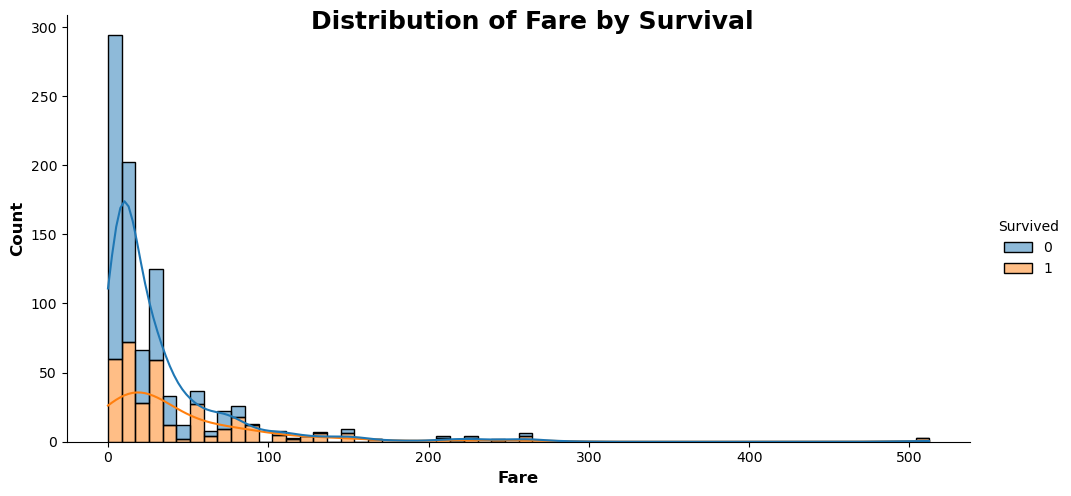

In [44]:
sns.displot(data = train_df, 
            x = 'Fare', 
            hue = 'Survived', 
            kde = True,
            height = 5,
            aspect = 2,
            multiple = 'stack')
plt.suptitle('Distribution of Fare by Survival',
             fontsize = plot_title_dict['fontsize'],
             fontweight = plot_title_dict['fontweight'])
plt.ylabel('Count', fontdict = plot_axis_dict)
plt.xlabel('Fare', fontdict = plot_axis_dict)
plt.show()

In [45]:
missing_fare_cols = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Ticket_P']
fare_missing_df = train_df[missing_fare_cols + ['Fare']]\
    .dropna()\
    .groupby(missing_fare_cols, as_index = False)\
    .median()
fare_missing_df.columns = fare_missing_df.columns.str.replace('Fare', 'Fare_Median')

fare_missing_df

,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Ticket_P,Fare_Median
0,0,0,1,0,0,1,0,8.0500
1,0,0,1,0,0,1,1,16.7000
2,0,0,1,0,1,0,0,7.7500
3,0,0,1,1,0,0,0,7.8958
4,0,1,0,0,0,1,0,13.7500
5,0,1,0,0,0,1,1,10.5000
6,0,1,0,0,1,0,0,12.3500
7,0,1,0,1,0,0,0,27.7208
8,0,1,0,1,0,0,1,24.0000
9,1,0,0,0,0,1,0,52.5542


In [46]:
for df in df_list:
    df.loc[df['Fare'].isnull(), 'Fare_Missing'] = 1
    df['Fare_Missing'] = df['Fare_Missing'].fillna(0).astype(int)
    df['Fare_Median'] = df.merge(fare_missing_df, on = missing_fare_cols, how = 'left')['Fare_Median']
    df.loc[df['Fare'].isnull(), 'Fare'] = df['Fare_Median']
    df.drop(['Fare_Median'], axis = 1, inplace = True)

for p, d in zip(plot_list, df_list):
    p['Fare'] = d.copy()['Fare']

train_df.head()

,PassengerId,Survived,Age,Fare,Cabin,Ticket_A,Ticket_C,Ticket_Numeric,Ticket_Other,Ticket_P,...,Num_Spouse,Num_Children,Num_Siblings,Num_Nannies,Num_Family,Pax_Ticket,Pclass_1,Pclass_2,Pclass_3,Fare_Missing
0,1,0,22,7.2500,NaN,1,0,0,0,0,...,0,0,1,0,1,1,0,0,1,0
1,2,1,38,71.2833,C85,0,0,0,0,1,...,2,0,0,0,2,2,1,0,0,0
2,3,1,26,7.9250,NaN,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,4,1,35,53.1000,C123,0,0,1,0,0,...,2,0,0,0,2,2,1,0,0,0
4,5,0,35,8.0500,NaN,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0


In [47]:
# for df in df_list:
#     df['Fare_Log'] = np.log(df['Fare'])
#     df.loc[df['Fare_Log'].isin([np.inf, -np.inf]), 'Fare_Log'] = 0
#     df.drop(['Fare'], axis = 1, inplace = True)

# plot_df['Fare_Log'] = train_df['Fare_Log']

# train_df.head()

In [48]:
# sns.displot(data = train_df, 
#             x = 'Fare_Log', 
#             hue = 'Survived', 
#             kde = True,
#             height = 5,
#             aspect = 2,
#             multiple = 'stack')
# plt.suptitle('Distribution of Fare (Log) by Survival')
# plt.show()

In [49]:
# num_bins = 10
# train_df['Fare_Interval'] = pd.qcut(train_df['Fare'], num_bins, precision = 4)

# fare_int_df = train_df\
#     .groupby(['Fare_Interval'], as_index = False)\
#     .agg(Survived = ('Survived', 'mean'),
#          Count = ('Fare_Interval', 'count'))
# fare_int_df['Fare'] = range(num_bins)

# fig, axs = plt.subplots(figsize = (22, 9))
# sns.countplot(x = 'Fare_Interval', hue = 'Survived', data = train_df)
# plt.title('Distribution of Passengers By Fare Interval and Survival')
# plt.show()

# fare_int_df

In [50]:
# for df in df_list:
#     df['Fare'] = [[b for i, b in zip(fare_int_df['Fare_Interval'], fare_int_df['Fare']) if a in i][0] for a in df['Fare']]
# train_df.drop(['Fare_Interval'], axis = 1, inplace = True)

# train_df.head()

# 4.6. Cabin
1. Extract Deck from Cabin: First Cabin letter is the Deck
2. Do not impute missing cabin; group together as Deck X
3. Drop Cabin

,PassengerId,Survived,Age,Fare,Cabin,Ticket_A,Ticket_C,Ticket_Numeric,Ticket_Other,Ticket_P,...,Num_Children,Num_Siblings,Num_Nannies,Num_Family,Pax_Ticket,Pclass_1,Pclass_2,Pclass_3,Fare_Missing,Deck
0,1,0,22,7.2500,NaN,1,0,0,0,0,...,0,1,0,1,1,0,0,1,0,X
1,2,1,38,71.2833,C85,0,0,0,0,1,...,0,0,0,2,2,1,0,0,0,C
2,3,1,26,7.9250,NaN,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,X
3,4,1,35,53.1000,C123,0,0,1,0,0,...,0,0,0,2,2,1,0,0,0,C
4,5,0,35,8.0500,NaN,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,X


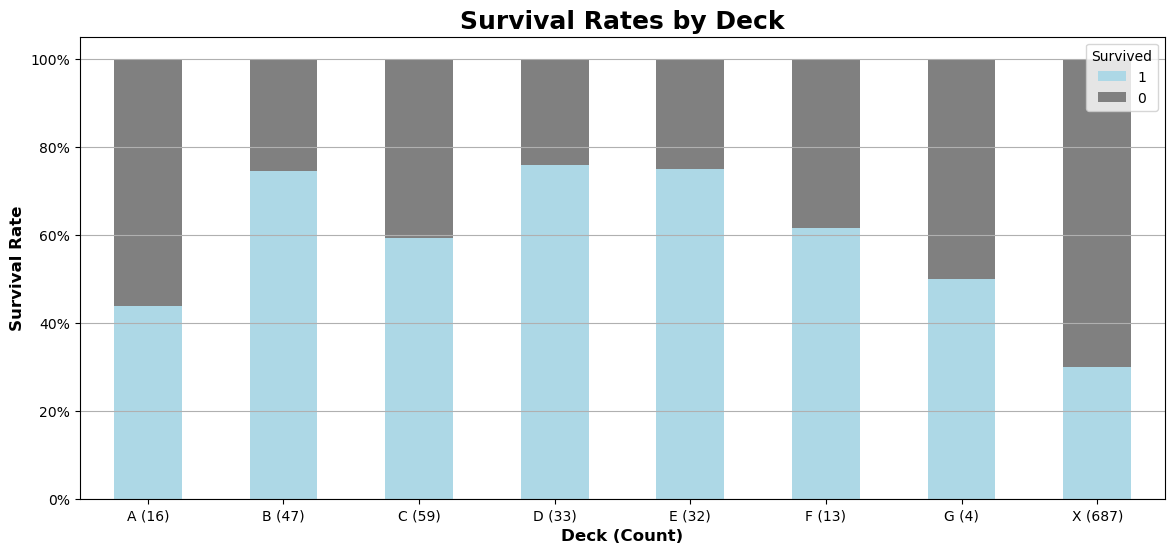

In [51]:
for df in df_list:
    df['Deck'] = [re.sub(r'\d+', '', c.split()[0])for c in df['Cabin'].fillna('X')]
    df.loc[df['Deck'] == 'T', 'Deck'] = 'A'

surv_percent_fun('Deck', (14, 6))
train_df.head()

In [52]:
for p, d in zip(plot_list, df_list):
    p['Deck'] = d.copy()['Deck']

train_df = pd.get_dummies(train_df, columns = ['Deck'], drop_first = False)
test_df = pd.get_dummies(test_df, columns = ['Deck'], drop_first = False)
df_list = [train_df, test_df]

for df in df_list:
    for c in [c for c in df.columns if 'Deck' in c]:
        df[c] = df[c].astype(int)
    df.drop(['Cabin'], axis = 1, inplace = True)

train_df.head()

,PassengerId,Survived,Age,Fare,Ticket_A,Ticket_C,Ticket_Numeric,Ticket_Other,Ticket_P,Ticket_SC,...,Pclass_3,Fare_Missing,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_X
0,1,0,22,7.2500,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,2,1,38,71.2833,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,3,1,26,7.9250,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,4,1,35,53.1000,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,5,0,35,8.0500,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1


# 4.7. Passenger ID
1. Drop from training set

In [53]:
train_df.drop(['PassengerId'], axis = 1, inplace = True)

train_df.head()

,Survived,Age,Fare,Ticket_A,Ticket_C,Ticket_Numeric,Ticket_Other,Ticket_P,Ticket_SC,Ticket_SO,...,Pclass_3,Fare_Missing,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_X
0,0,22,7.2500,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,1,38,71.2833,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,26,7.9250,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,1,35,53.1000,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,35,8.0500,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


# 4.8. Able Bodie

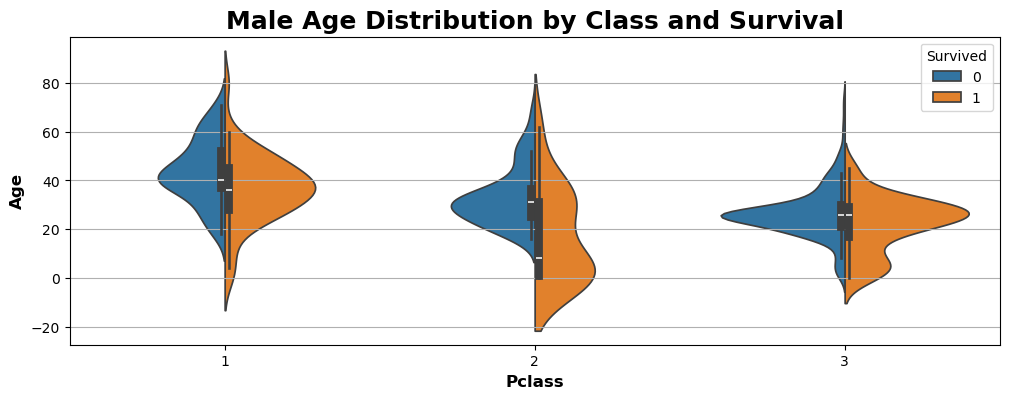

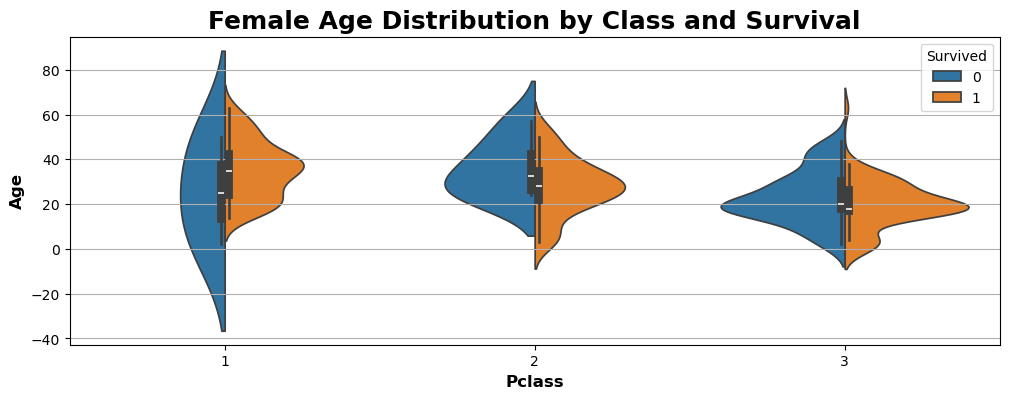

In [54]:
for s in ['Male', 'Female']:
    f, ax = plt.subplots(figsize = (12, 4))
    sns.violinplot(data = plot_df[plot_df['Sex'] == s], x = "Pclass", y = "Age", hue = "Survived", split = True, ax = ax)
    ax.set_title(s + ' Age Distribution by Class and Survival', fontdict = plot_title_dict)
    plt.ylabel('Age', fontdict = plot_axis_dict)
    plt.xlabel('Pclass', fontdict = plot_axis_dict)
    plt.grid(axis = 'y')
    plt.show()

In [55]:
for p, d in zip(plot_list, df_list):
    p.loc[p['Age'] < 20, 'Able_Body'] = 'Young'
    p.loc[(p['Age'] >= 20) & (p['Age'] <= 40), 'Able_Body'] = 'Able'
    p['Able_Body'] = p['Able_Body'].fillna('Old').astype(str)
    p['Able_Group'] = [s + '_' + a + '_' + str(c) for a, s, c in zip(p['Able_Body'], p['Sex'], p['Pclass'])]
    d['Able_Group'] = [s + '_' + a + '_' + str(c) for a, s, c in zip(p['Able_Body'], p['Sex'], p['Pclass'])]

train_df = pd.get_dummies(train_df, columns = ['Able_Group'], drop_first = False)
test_df = pd.get_dummies(test_df, columns = ['Able_Group'], drop_first = False)
df_list = [train_df, test_df]

for df in df_list:
    for c in [c for c in df.columns if 'Able_Group' in c]:
        df[c] = df[c].astype(int)

train_df.head()

,Survived,Age,Fare,Ticket_A,Ticket_C,Ticket_Numeric,Ticket_Other,Ticket_P,Ticket_SC,Ticket_SO,...,Able_Group_Female_Young_3,Able_Group_Male_Able_1,Able_Group_Male_Able_2,Able_Group_Male_Able_3,Able_Group_Male_Old_1,Able_Group_Male_Old_2,Able_Group_Male_Old_3,Able_Group_Male_Young_1,Able_Group_Male_Young_2,Able_Group_Male_Young_3
0,0,22,7.2500,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1,38,71.2833,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,26,7.9250,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,35,53.1000,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,35,8.0500,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


# 5. Add Interactions

Explore interactions between Fare, Age, and Family Size

In [56]:
for df in df_list:
    df['Title_Mr*Num_Children'] = df['Title_Mr'] * df['Num_Children']
    df['Fare*Age*Male'] = df['Fare'] * df['Age'] * df['Sex_Male']
    # df['FS*Age'] = df['FamilySize'] * df['Age']    
    # df['Female*Age'] = df['Sex_Female'] * df['Age']
    # df['Male*Fare'] = df['Sex_Male'] * df['Fare']
    
    # # df['Title_Mr*Pclass_1*Age'] = df['Title_Mr'] * df['Pclass_1'] * df['Age']
    # # df['Title_Mr*Pclass_2*Age'] = df['Title_Mr'] * df['Pclass_2'] * df['Age']
    # # df['Title_Mr*Pclass_3*Age'] = df['Title_Mr'] * df['Pclass_3'] * df['Age']
    # # df['FS*Age'] = df['FamilySize'] * df['Age']    
    # # df['Female*Age'] = df['Sex_Female'] * df['Age']
    # # df['Male*Fare'] = df['Sex_Male'] * df['Fare']
    # # df['Fare*Age'] = df['Fare'] * df['Age']
    # df['Male*Age*Pclass_1'] = df['Sex_Male'] * df['Age'] * df['Pclass_1']
    # df['Male*Age*Pclass_2'] = df['Sex_Male'] * df['Age'] * df['Pclass_2']
    # df['Male*Age*Pclass_3'] = df['Sex_Male'] * df['Age'] * df['Pclass_3']
    # # df['Female*Age*Pclass_1'] = df['Sex_Female'] * df['Age'] * df['Pclass_1']
    # # df['Female*Age*Pclass_2'] = df['Sex_Female'] * df['Age'] * df['Pclass_2']
    # # df['Female*Age*Pclass_3'] = df['Sex_Female'] * df['Age'] * df['Pclass_3']
    
train_df.head()

,Survived,Age,Fare,Ticket_A,Ticket_C,Ticket_Numeric,Ticket_Other,Ticket_P,Ticket_SC,Ticket_SO,...,Able_Group_Male_Able_2,Able_Group_Male_Able_3,Able_Group_Male_Old_1,Able_Group_Male_Old_2,Able_Group_Male_Old_3,Able_Group_Male_Young_1,Able_Group_Male_Young_2,Able_Group_Male_Young_3,Title_Mr*Num_Children,Fare*Age*Male
0,0,22,7.2500,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,159.50
1,1,38,71.2833,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.00
2,1,26,7.9250,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.00
3,1,35,53.1000,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.00
4,0,35,8.0500,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,281.75


# 6. Score Models
1. Final check for missing features
2. Scale features
3. Undersample majority class
4. Train candidate models and store model and probabilities in dictionary
5. Rank candidate models by cross-validated accuracy 

**Candidate Models:**
1. Logistic Regression
2. Support Vector Machines
3. KNN
4. Naive Bayes
5. Perceptron
6. Linear SVC
7. Stochastic Gradient Decent
8. Decision Tree
9. Random Forest

In [57]:
# for df in df_list:
#     for c in ['Sex_Male', 'Sex_Female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Title_Mr']:
#         df.drop([c], axis = 1, inplace = True)

In [58]:
pd.concat([train_df, test_df]).isnull().sum().sort_values(ascending = False)

PassengerId                 891
Survived                    418
Fare                          0
Deck_E                        0
Able_Group_Female_Able_3      0
                           ... 
Num_Parents                   0
Num_Spouse                    0
Num_Children                  0
Num_Siblings                  0
Num_Nannies                   0
Length: 71, dtype: int64

In [59]:
train_df['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [60]:
# Split X, Y
X_train = train_df.drop("Survived", axis = 1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis = 1).copy()

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [61]:
# Oversampling using RandomOverSampler
oversample = RandomOverSampler(sampling_strategy = 'minority')
X_train_scaled_over, Y_train_over = oversample.fit_resample(X_train_scaled, Y_train)
Y_train_over.value_counts()

Survived
0    549
1    549
Name: count, dtype: int64

In [62]:
# Undersampling using RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy = 'majority')
X_train_scaled_under, Y_train_under = undersample.fit_resample(X_train_scaled, Y_train)
Y_train_under.value_counts()

Survived
0    342
1    342
Name: count, dtype: int64

In [63]:
# Create data dictionaries
base_data_dict = {'X_Train': X_train,
                  'Y_Train': Y_train,
                  'X_Test': X_test}

scaled_data_dict = {'X_Train': X_train_scaled,
                    'Y_Train': Y_train,
                    'X_Test': X_test_scaled}

under_scaled_data_dict = {'X_Train': X_train_scaled_under,
                          'Y_Train': Y_train_under,
                          'X_Test': X_test_scaled}

over_scaled_data_dict = {'X_Train': X_train_scaled_over,
                         'Y_Train': Y_train_over,
                         'X_Test': X_test_scaled}

In [64]:
# Candidate Models
logreg = LogisticRegression()
svc = SVC(probability = True)
knn = KNeighborsClassifier(n_neighbors = 3)
gaussian = GaussianNB()
perceptron = Perceptron()
linear_svc = LinearSVC()
sgd = SGDClassifier()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier(n_estimators = 100)
xgb_boost = XGBClassifier(n_estimators = 100)

In [65]:
# Select what data to use for training: Original, Scaled, Undersampled, or Oversampled
model_dict = {'Logistic Regression': {'Model': logreg} | scaled_data_dict,
              'Support Vector Machines': {'Model': svc} | scaled_data_dict,
              'KNN': {'Model': knn} | scaled_data_dict,
              'Naive Bayes': {'Model': gaussian} | scaled_data_dict,
              'Perceptron': {'Model': perceptron} | scaled_data_dict,
              'Linear SVC': {'Model': linear_svc} | scaled_data_dict,
              'Stochastic Gradient Decent': {'Model': sgd} | scaled_data_dict,
              'Decision Tree': {'Model': decision_tree} | scaled_data_dict,
              'Random Forest': {'Model': random_forest} | scaled_data_dict,
              'XGBoost': {'Model': xgb_boost} | scaled_data_dict,
              'Random Forest Tuned' : {'Model': ''} | scaled_data_dict,
              'XGBoost Tuned': {'Model': ''} | scaled_data_dict}

In [66]:
models_df = pd.DataFrame()

for d in model_dict:
    if d not in ['Random Forest Tuned', 'XGBoost Tuned']:
        print('Training ' + d)

        # First do Stratified Training and capture stratified accuracy
        skf = StratifiedKFold(n_splits = 5, shuffle = True)
    
        strat_acc = []
        for fold, (train_index, test_index) in enumerate(skf.split(model_dict[d]['X_Train'], model_dict[d]['Y_Train'])):
            strat_m = model_dict[d]['Model']
            X_strat_train = model_dict[d]['X_Train'][train_index]
            X_strat_val = model_dict[d]['X_Train'][test_index]
            y_strat_train = model_dict[d]['Y_Train'][train_index]
            y_strat_val = model_dict[d]['Y_Train'][test_index]
        
            # Stratified Training
            strat_m.fit(X_strat_train, y_strat_train)
            y_strat_pred = strat_m.predict(X_strat_val)
            strat_acc.append(accuracy_score(y_strat_val, y_strat_pred))
    
        # Re-Fit Model
        model_dict[d]['Model'].fit(model_dict[d]['X_Train'], model_dict[d]['Y_Train'])
    
        # Store Probabilities (not all models support predict_proba)
        # Only need this in case model is later included in ensemble
        if d not in ['Perceptron', 'Linear SVC', 'Stochastic Gradient Decent']:        
            model_dict[d]['CV_Prob'] = cross_val_predict(model_dict[d]['Model'],
                                                         model_dict[d]['X_Train'],
                                                         model_dict[d]['Y_Train'],
                                                         cv = 10,
                                                         method = 'predict_proba')[:,1]
            model_dict[d]['Train_Prob'] = model_dict[d]['Model'].predict_proba(model_dict[d]['X_Train'])[:,1]
            model_dict[d]['Test_Prob'] = model_dict[d]['Model'].predict_proba(model_dict[d]['X_Test'])[:,1]
    
        # Calculate CV Accuracy and AUC
        cv_scores_acc = cross_val_score(model_dict[d]['Model'], 
                                        model_dict[d]['X_Train'],
                                        model_dict[d]['Y_Train'], 
                                        cv = 10, 
                                        scoring = "accuracy")
        cv_scores_auc = cross_val_score(model_dict[d]['Model'], 
                                        model_dict[d]['X_Train'],
                                        model_dict[d]['Y_Train'], 
                                        cv = 10, 
                                        scoring = "roc_auc")
        model_score = model_dict[d]['Model'].score(model_dict[d]['X_Train'], model_dict[d]['Y_Train'])

        # Append metrics
        df = pd.DataFrame({'Model': [d],
                           'Score': [round(model_score * 100, 2)],
                           'CV_Accuracy_Mean': [round(cv_scores_acc.mean() * 100, 2)],
                           'Stratified_Accuracy_Mean': [round(np.mean(strat_acc) * 100, 2)],                       
                           'CV_Accuracy_SD': [round(cv_scores_acc.std() * 100, 2)],
                           'CV_ROC_AUC_Mean': [round(cv_scores_auc.mean() * 100, 2)],
                           'CV_ROC_AUC_SD': [round(cv_scores_auc.std() * 100, 2)]})
        models_df = pd.concat([models_df, df]).reset_index(drop = True)

models_df.sort_values(by = 'CV_Accuracy_Mean', ascending = False)

Training Logistic Regression
Training Support Vector Machines
Training KNN
Training Naive Bayes
Training Perceptron
Training Linear SVC
Training Stochastic Gradient Decent
Training Decision Tree
Training Random Forest
Training XGBoost


,Model,Score,CV_Accuracy_Mean,Stratified_Accuracy_Mean,CV_Accuracy_SD,CV_ROC_AUC_Mean,CV_ROC_AUC_SD
0,Logistic Regression,85.52,83.17,83.06,3.40,85.93,5.36
1,Support Vector Machines,87.54,83.06,81.71,4.07,85.29,6.20
5,Linear SVC,85.30,82.72,82.04,3.67,85.86,5.13
9,XGBoost,98.54,82.61,81.93,4.28,86.91,5.90
8,Random Forest,99.21,82.50,81.71,4.42,87.41,4.98
2,KNN,88.33,80.03,79.80,4.10,82.95,5.46
7,Decision Tree,99.21,79.25,78.34,4.90,77.04,5.28
3,Naive Bayes,80.47,78.80,78.57,3.51,84.11,4.23
6,Stochastic Gradient Decent,65.43,77.10,78.34,10.32,80.56,5.97
4,Perceptron,79.57,75.76,76.55,5.90,80.26,5.87


In [67]:
if kaggle_env == False:
    display(pd.read_pickle(kaggle_path + '/baseline/baseline_79186').sort_values(by = 'CV_Accuracy_Mean', ascending = False))

,Model,Score,CV_Accuracy_Mean,Stratified_Accuracy_Mean,CV_Accuracy_SD,CV_ROC_AUC_Mean,CV_ROC_AUC_SD
0,Logistic Regression,85.52,83.17,82.16,3.40,85.93,5.36
1,Support Vector Machines,87.54,83.06,82.60,4.07,85.29,6.20
5,Linear SVC,85.30,82.72,82.38,3.67,85.86,5.13
9,XGBoost,98.54,82.61,82.27,4.28,86.91,5.90
8,Random Forest,99.21,82.50,81.82,4.90,87.29,5.18
2,KNN,88.33,80.03,80.02,4.10,82.95,5.46
7,Decision Tree,99.21,79.81,80.36,4.42,77.12,5.41
3,Naive Bayes,80.47,78.80,78.45,3.51,84.11,4.23
6,Stochastic Gradient Decent,76.66,77.79,77.33,5.18,82.40,5.88
4,Perceptron,79.57,75.76,76.55,5.90,80.26,5.87


In [ ]:
# # Save as baseline if results favorable
# models_df.to_pickle(kaggle_path + '/baseline/baseline_79186')

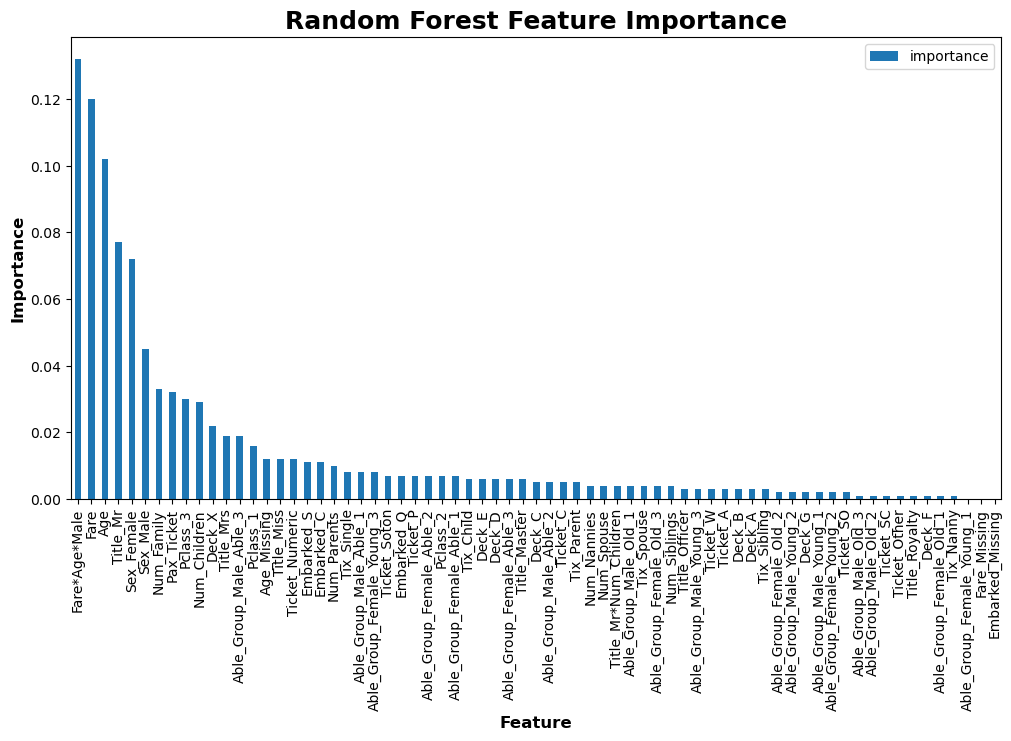

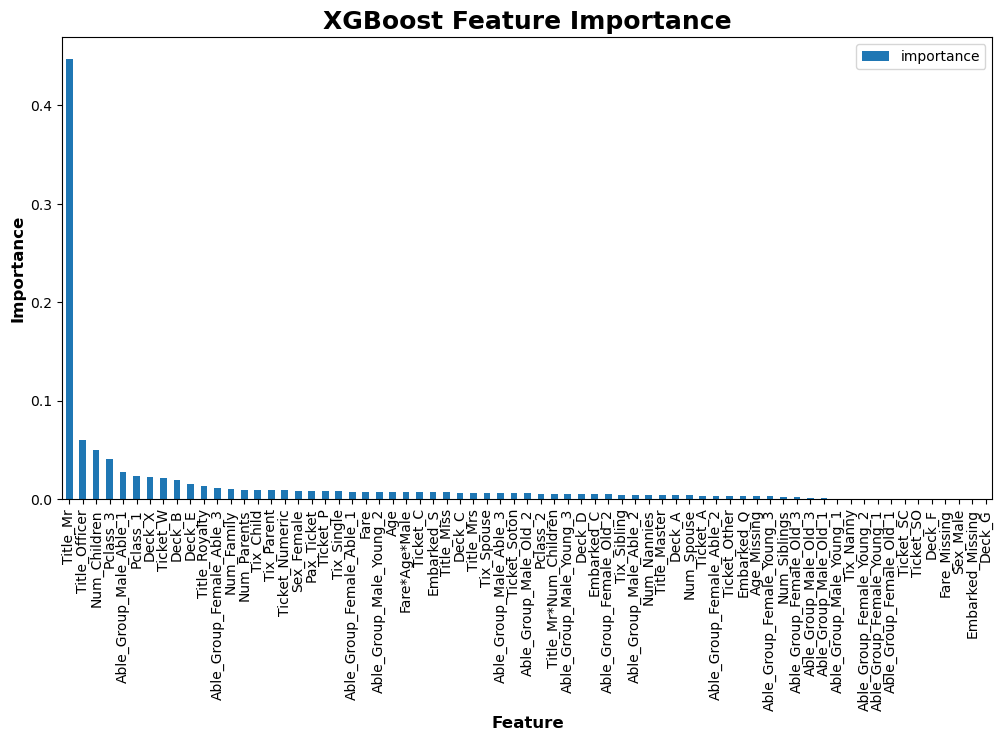

In [68]:
for m in ['Random Forest', 'XGBoost']:
    feature_importance_fun(m)

# 7. Tune Hyper Parameters

1. Create model objective function with paramater space
2. Create and run the optimization process with 100 trials
3. Retrieve the best parameter values and fine tune model
4. Train model with best parameter and store in dictionary
5. Evaluate feature importance

References:

1. https://www.youtube.com/watch?v=D9xPjkOwpNk

# 7.1 Random Forest Hyper Parameter Tuning

In [69]:
def rf_obj_fun(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10)
    }

    model = RandomForestClassifier(**param,)
    score = cross_val_score(model, 
                            model_dict['Random Forest Tuned']['X_Train'],
                            model_dict['Random Forest Tuned']['Y_Train'],
                            cv = 3, 
                            scoring = "roc_auc").mean()
    return score

rf_study = optuna.create_study(study_name = 'rf_study_cpu', direction = "maximize")
rf_study.optimize(rf_obj_fun,
                  n_trials = 10,
                  show_progress_bar = True,
                  n_jobs = -1)

[I 2025-12-02 11:40:37,568] A new study created in memory with name: rf_study_cpu
Best trial: 4. Best value: 0.869811:  10%|▋      | 1/10 [00:05<00:47,  5.25s/it]

[I 2025-12-02 11:40:42,819] Trial 4 finished with value: 0.8698111398715368 and parameters: {'n_estimators': 207, 'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 6}. Best is trial 4 with value: 0.8698111398715368.


Best trial: 6. Best value: 0.873614:  30%|██     | 3/10 [00:06<00:11,  1.60s/it]

[I 2025-12-02 11:40:43,894] Trial 1 finished with value: 0.8727191384654714 and parameters: {'n_estimators': 252, 'max_depth': 16, 'min_samples_split': 18, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8727191384654714.
[I 2025-12-02 11:40:44,083] Trial 6 finished with value: 0.8736139072636053 and parameters: {'n_estimators': 265, 'max_depth': 22, 'min_samples_split': 13, 'min_samples_leaf': 4}. Best is trial 6 with value: 0.8736139072636053.


Best trial: 6. Best value: 0.873614:  40%|██▊    | 4/10 [00:09<00:13,  2.17s/it]

[I 2025-12-02 11:40:47,131] Trial 9 finished with value: 0.8731505448502861 and parameters: {'n_estimators': 441, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 6 with value: 0.8736139072636053.


Best trial: 6. Best value: 0.873614:  50%|███▌   | 5/10 [00:11<00:10,  2.06s/it]

[I 2025-12-02 11:40:49,006] Trial 8 finished with value: 0.871760457610328 and parameters: {'n_estimators': 618, 'max_depth': 16, 'min_samples_split': 11, 'min_samples_leaf': 7}. Best is trial 6 with value: 0.8736139072636053.


Best trial: 0. Best value: 0.874349: 100%|██████| 10/10 [00:14<00:00,  1.48s/it]

[I 2025-12-02 11:40:52,186] Trial 7 finished with value: 0.8719521937813569 and parameters: {'n_estimators': 891, 'max_depth': 22, 'min_samples_split': 12, 'min_samples_leaf': 7}. Best is trial 6 with value: 0.8736139072636053.
[I 2025-12-02 11:40:52,289] Trial 2 finished with value: 0.87167257853194 and parameters: {'n_estimators': 910, 'max_depth': 12, 'min_samples_split': 19, 'min_samples_leaf': 6}. Best is trial 6 with value: 0.8736139072636053.
[I 2025-12-02 11:40:52,310] Trial 3 finished with value: 0.869076151215927 and parameters: {'n_estimators': 938, 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 6 with value: 0.8736139072636053.
[I 2025-12-02 11:40:52,336] Trial 5 finished with value: 0.8722717540664046 and parameters: {'n_estimators': 945, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 6 with value: 0.8736139072636053.
[I 2025-12-02 11:40:52,353] Trial 0 finished with value: 0.8743488959192152 and parameters: 

In [70]:
rf_best_params = rf_study.best_params
print(f"\nBest parameters: {rf_best_params}")


Best parameters: {'n_estimators': 925, 'max_depth': 29, 'min_samples_split': 8, 'min_samples_leaf': 2}


In [71]:
rf_tuned = RandomForestClassifier(n_estimators = rf_best_params['n_estimators'],
                                  max_depth = rf_best_params['max_depth'],
                                  min_samples_split = rf_best_params['min_samples_split'],
                                  min_samples_leaf = rf_best_params['min_samples_leaf'])
rf_tuned.fit(model_dict['Random Forest Tuned']['X_Train'],
             model_dict['Random Forest Tuned']['Y_Train'])
model_dict['Random Forest Tuned']['Model'] = rf_tuned

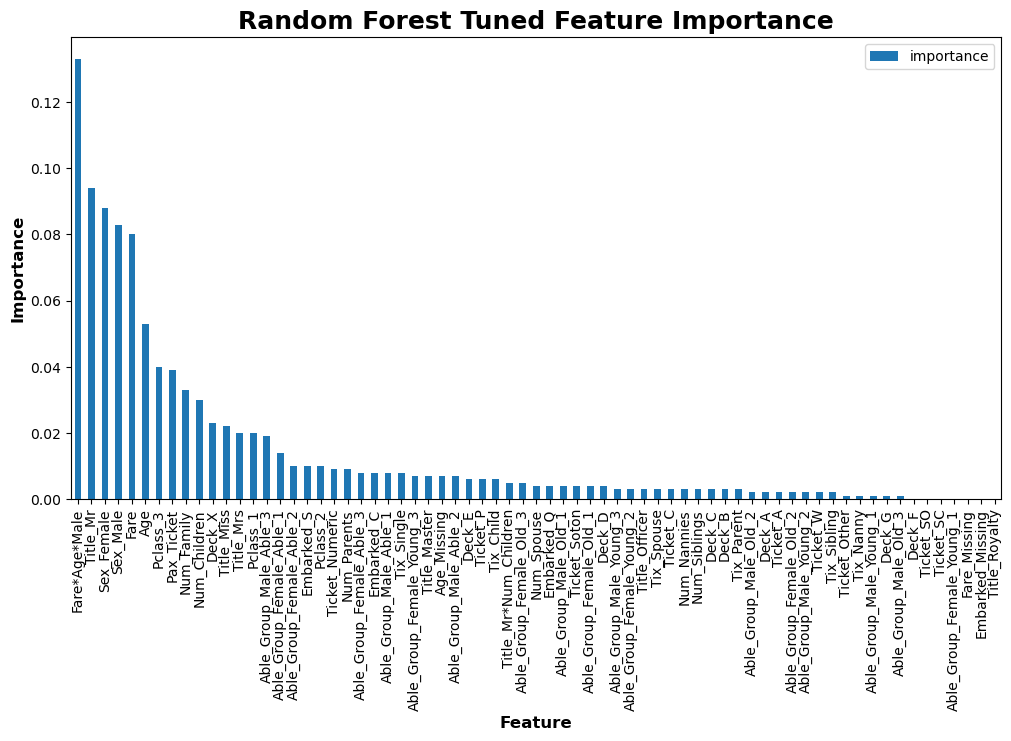

In [72]:
feature_importance_fun('Random Forest Tuned')

# 7.2 XGBoost Hyper Parameter Tuning

In [73]:
def xgb_obj_fun(trial):
    param = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 5),
    }
    
    model = xgb.XGBClassifier(**param)
    score = cross_val_score(model, 
                            model_dict['XGBoost Tuned']['X_Train'],
                            model_dict['XGBoost Tuned']['Y_Train'], 
                            cv = 3, 
                            scoring = "roc_auc").mean()
    return score

xgb_study = optuna.create_study(study_name = 'xgboost_study_cpu', direction = "maximize")
xgb_study.optimize(xgb_obj_fun,
                   n_trials = 10,
                   show_progress_bar = True,
                   n_jobs = -1)

[I 2025-12-02 11:40:53,374] A new study created in memory with name: xgboost_study_cpu
Best trial: 4. Best value: 0.873302:  10%|▋      | 1/10 [00:14<02:07, 14.16s/it]

[I 2025-12-02 11:41:07,531] Trial 7 finished with value: 0.8683251845460647 and parameters: {'max_depth': 8, 'learning_rate': 0.06251471857787629, 'n_estimators': 311, 'subsample': 0.7128757780899133, 'colsample_bytree': 0.9935520569034695, 'min_child_weight': 8, 'gamma': 3.9892879078466366}. Best is trial 7 with value: 0.8683251845460647.
[I 2025-12-02 11:41:07,535] Trial 4 finished with value: 0.8733023359856839 and parameters: {'max_depth': 8, 'learning_rate': 0.0602250515273527, 'n_estimators': 232, 'subsample': 0.695101636524261, 'colsample_bytree': 0.8654952458844827, 'min_child_weight': 2, 'gamma': 2.9967276553768807}. Best is trial 4 with value: 0.8733023359856839.


Best trial: 4. Best value: 0.873302:  40%|██▊    | 4/10 [00:21<00:25,  4.30s/it]

[I 2025-12-02 11:41:15,174] Trial 2 finished with value: 0.8719042597385998 and parameters: {'max_depth': 3, 'learning_rate': 0.039024654855058225, 'n_estimators': 333, 'subsample': 0.7469961118396395, 'colsample_bytree': 0.9539204905739103, 'min_child_weight': 10, 'gamma': 0.08527006465812503}. Best is trial 4 with value: 0.8733023359856839.
[I 2025-12-02 11:41:15,314] Trial 1 finished with value: 0.870402326398875 and parameters: {'max_depth': 9, 'learning_rate': 0.044504796921696635, 'n_estimators': 756, 'subsample': 0.9537337482652372, 'colsample_bytree': 0.8079143135198039, 'min_child_weight': 5, 'gamma': 4.094873966054325}. Best is trial 4 with value: 0.8733023359856839.


Best trial: 0. Best value: 0.874916:  50%|███▌   | 5/10 [00:22<00:15,  3.05s/it]

[I 2025-12-02 11:41:15,830] Trial 0 finished with value: 0.874916115425175 and parameters: {'max_depth': 7, 'learning_rate': 0.07505096347676057, 'n_estimators': 869, 'subsample': 0.7645393464535442, 'colsample_bytree': 0.820058869130764, 'min_child_weight': 5, 'gamma': 4.910024742194253}. Best is trial 0 with value: 0.874916115425175.


Best trial: 3. Best value: 0.876865:  60%|████▏  | 6/10 [00:23<00:09,  2.30s/it]

[I 2025-12-02 11:41:16,557] Trial 5 finished with value: 0.8650976256670821 and parameters: {'max_depth': 9, 'learning_rate': 0.02794919508527654, 'n_estimators': 645, 'subsample': 0.5766015275982697, 'colsample_bytree': 0.6645822730053461, 'min_child_weight': 10, 'gamma': 2.2781454951171924}. Best is trial 0 with value: 0.874916115425175.
[I 2025-12-02 11:41:16,601] Trial 3 finished with value: 0.8768654331639665 and parameters: {'max_depth': 3, 'learning_rate': 0.07534016441777198, 'n_estimators': 770, 'subsample': 0.6001265558921098, 'colsample_bytree': 0.7643540368808017, 'min_child_weight': 5, 'gamma': 2.3797879175262597}. Best is trial 3 with value: 0.8768654331639665.


Best trial: 3. Best value: 0.876865:  80%|█████▌ | 8/10 [00:23<00:02,  1.27s/it]

[I 2025-12-02 11:41:16,858] Trial 6 finished with value: 0.873893522513022 and parameters: {'max_depth': 8, 'learning_rate': 0.06246504062406749, 'n_estimators': 980, 'subsample': 0.920586387589793, 'colsample_bytree': 0.9402848644228016, 'min_child_weight': 6, 'gamma': 2.7767960155355236}. Best is trial 3 with value: 0.8768654331639665.


Best trial: 3. Best value: 0.876865:  90%|██████▎| 9/10 [00:23<00:01,  1.06s/it]

[I 2025-12-02 11:41:17,288] Trial 9 finished with value: 0.8734461381139553 and parameters: {'max_depth': 4, 'learning_rate': 0.02312910068296117, 'n_estimators': 956, 'subsample': 0.85124030512748, 'colsample_bytree': 0.6544392446345274, 'min_child_weight': 3, 'gamma': 3.477604584255212}. Best is trial 3 with value: 0.8768654331639665.


Best trial: 3. Best value: 0.876865: 100%|██████| 10/10 [00:24<00:00,  2.43s/it]

[I 2025-12-02 11:41:17,634] Trial 8 finished with value: 0.8687086568881219 and parameters: {'max_depth': 8, 'learning_rate': 0.01005517309531779, 'n_estimators': 577, 'subsample': 0.648792998515933, 'colsample_bytree': 0.9838417731870148, 'min_child_weight': 10, 'gamma': 0.7069043896090299}. Best is trial 3 with value: 0.8768654331639665.


In [74]:
xgb_best_params = xgb_study.best_params
print(f"\nBest parameters: {xgb_best_params}")


Best parameters: {'max_depth': 3, 'learning_rate': 0.07534016441777198, 'n_estimators': 770, 'subsample': 0.6001265558921098, 'colsample_bytree': 0.7643540368808017, 'min_child_weight': 5, 'gamma': 2.3797879175262597}


In [75]:
xgb_tuned = XGBClassifier(n_estimators = xgb_best_params['n_estimators'],
                          max_depth = xgb_best_params['max_depth'],
                          learning_rate = xgb_best_params['learning_rate'],
                          subsample = xgb_best_params['subsample'],
                          colsample_bytree = xgb_best_params['colsample_bytree'],
                          min_child_weight = xgb_best_params['min_child_weight'],
                          gamma = xgb_best_params['gamma'])
xgb_tuned.fit(model_dict['XGBoost Tuned']['X_Train'],
              model_dict['XGBoost Tuned']['Y_Train'])
model_dict['XGBoost Tuned']['Model'] = xgb_tuned

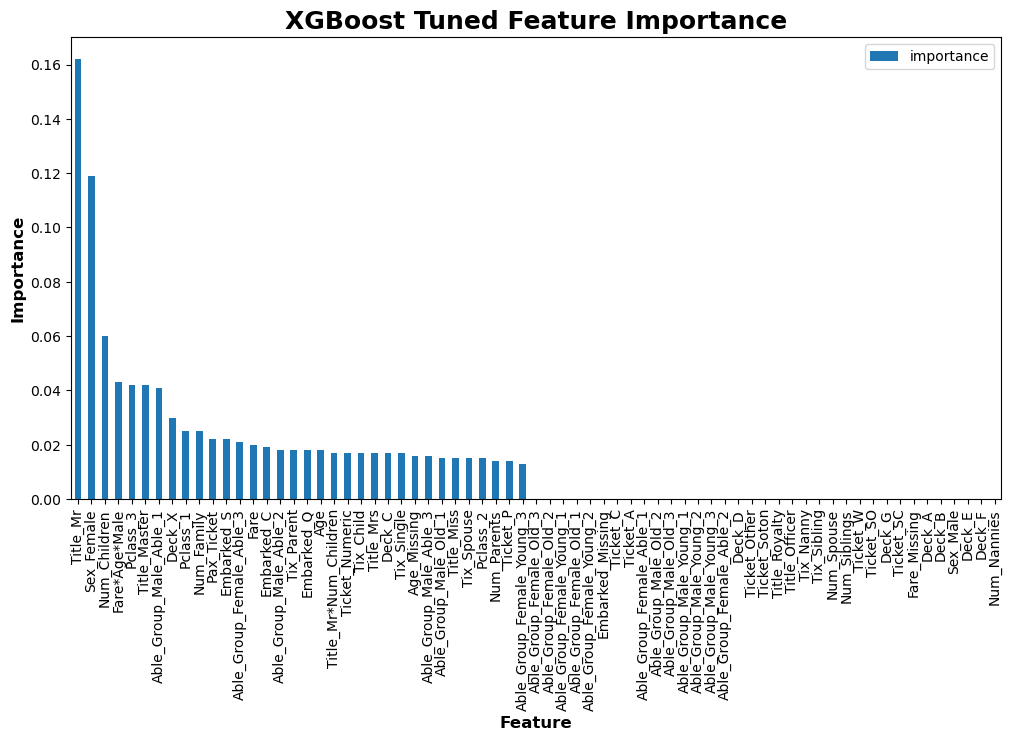

In [76]:
feature_importance_fun('XGBoost Tuned')

# 8. Calculate Model Probabilities

1. Narrow down initial list of models with best candidates
2. Calculate and store model probabilities
3. Evaluate Metrics

Metrics:
1. Confusion Matrix
2. Precision and Recall
3. F1 Score
4. ROC AUC Curve and Score

In [77]:
final_options = ['Logistic Regression',
                 'Support Vector Machines',
                 'Random Forest Tuned',
                 'XGBoost Tuned']

for final_model in final_options:
    model_dict[final_model]['CV_Prob'] = cross_val_predict(model_dict[final_model]['Model'],
                                                           model_dict[final_model]['X_Train'],
                                                           model_dict[final_model]['Y_Train'],
                                                           cv = 10,
                                                           method = 'predict_proba')[:,1]
    model_dict[final_model]['Train_Prob'] = model_dict[final_model]['Model'].predict_proba(model_dict[final_model]['X_Train'])[:,1]
    model_dict[final_model]['Test_Prob'] = model_dict[final_model]['Model'].predict_proba(model_dict[final_model]['X_Test'])[:,1]

In [78]:
final_metrics_df = pd.DataFrame()
fpr_list = []
tpr_list = []
conf_mat_list = []
roc_auc_list = []
for final_model in final_options:
    
    # Confusion Matrix
    cv_preds = [int(float(p) > 0.5) for p in model_dict[final_model]['CV_Prob']]
    model_confusion_matrix = confusion_matrix(model_dict[final_model]['Y_Train'], cv_preds)
    conf_mat_list.append(model_confusion_matrix)
    true_non_surv = model_confusion_matrix[0][0]
    true_surv = model_confusion_matrix[1][1]

    # ROC Curve
    y_train_prob = model_dict[final_model]['Train_Prob']
    model_fpr, model_tpr, model_thresholds = roc_curve(model_dict[final_model]['Y_Train'], y_train_prob)
    fpr_list.append(model_fpr)
    tpr_list.append(model_tpr)
    model_roc_auc = roc_auc_score(model_dict[final_model]['Y_Train'], y_train_prob)
    roc_auc_list.append(model_roc_auc)

    # Metrics
    model_precision = precision_score(model_dict[final_model]['Y_Train'], cv_preds)
    model_recall = recall_score(model_dict[final_model]['Y_Train'], cv_preds)
    model_f1 = f1_score(model_dict[final_model]['Y_Train'], cv_preds)

    final_metrics_df = pd.concat([final_metrics_df,
                                  pd.DataFrame({'Selected Model': [final_model],
                                                'Precision': [round(model_precision * 100, 2)],
                                                'Recall': [round(model_recall * 100, 2)],
                                                'F1 Score': [round(model_f1 * 100, 2)],
                                                'ROC AUC': [round(model_roc_auc * 100, 2)], 
                                                'Non Survivors': true_non_surv,
                                                'Survivors': true_surv,
                                                'Total Correct': true_non_surv + true_surv
                                               })]).reset_index(drop = True)
final_metrics_df.sort_values(by = 'Precision', ascending = False)

,Selected Model,Precision,Recall,F1 Score,ROC AUC,Non Survivors,Survivors,Total Correct
1,Support Vector Machines,82.21,71.64,76.56,92.43,496,245,741
2,Random Forest Tuned,81.64,72.81,76.97,96.26,493,249,742
0,Logistic Regression,81.37,72.81,76.85,90.66,492,249,741
3,XGBoost Tuned,80.78,72.51,76.43,93.24,490,248,738


# 9. Create Ensemble Models

SVC good at predicting true non survivors, but other models good at predicting survivors. Explore ensembles

Cannot include Perceptron, Linear SVC, Stochastic Gradient Decent

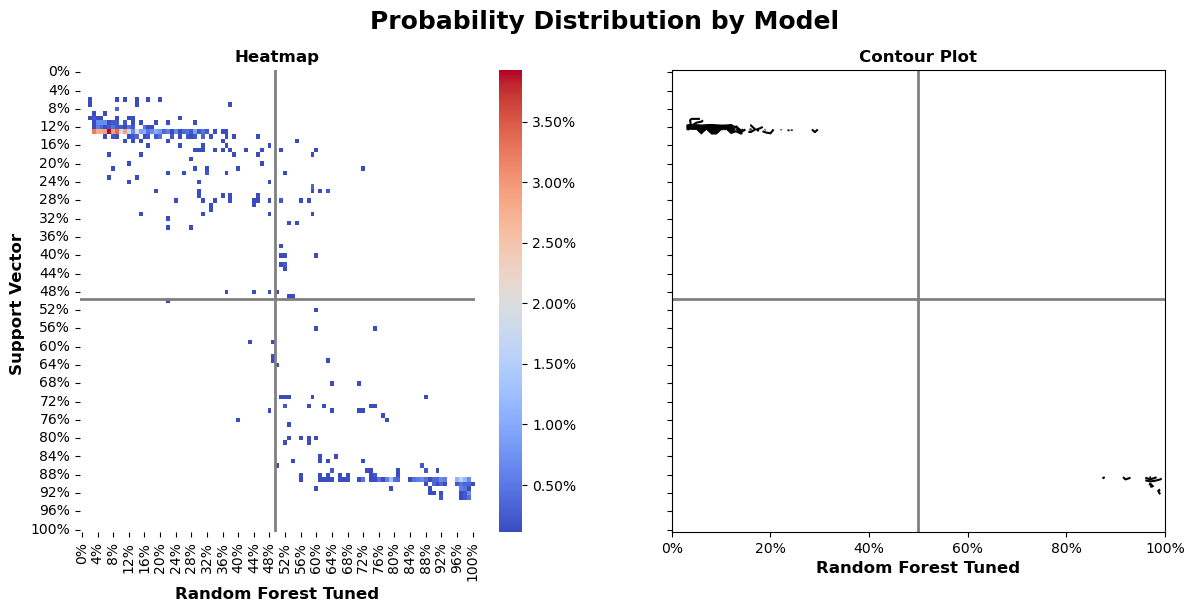

In [79]:
svc_train_prob_df = pd.DataFrame({'SVC': [round(p, 2) for p in model_dict['Support Vector Machines']['Train_Prob']]})
rfhp_train_prob_df = pd.DataFrame({'RF_HT': [round(p, 2) for p in model_dict['Random Forest Tuned']['Train_Prob']]})
svc_rfhp_heatmap_df = pd.concat([svc_train_prob_df, rfhp_train_prob_df], axis = 1)\
    .groupby(['SVC', 'RF_HT'], as_index = False)\
    .agg(Count = ('SVC', 'count'))
svc_rfhp_heatmap_df['Count'] = svc_rfhp_heatmap_df['Count'] / svc_rfhp_heatmap_df['Count'].sum()

x = np.linspace(0, 1, 101)
y = np.linspace(0, 1, 101)
svc_rfhp_heatmap_df = pd.DataFrame({'SVC': x})\
    .merge(pd.DataFrame({'RF_HT': y}), how = 'cross')\
    .merge(svc_rfhp_heatmap_df, on = ['SVC', 'RF_HT'], how = 'left')\
    .pivot(index = 'SVC', columns = 'RF_HT', values = 'Count')

# Plots
f, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (14, 6))

# Heatmap
sns.heatmap(svc_rfhp_heatmap_df, cmap = 'coolwarm', cbar_kws = {'format': mtick.PercentFormatter(xmax = 1)},  ax = ax1)
ax1.set_title("Heatmap", fontdict = plot_axis_dict)
ax1.set_ylabel('Support Vector ', fontdict = plot_axis_dict)
ax1.set_xlabel('Random Forest Tuned', fontdict = plot_axis_dict)
ax1.xaxis.set_major_formatter(mtick.PercentFormatter(xmax = 100))
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 100))
ax1.axvline(x = 50, linewidth = 2, color = 'grey')
ax1.axhline(y = 50, linewidth = 2, color = 'grey')

# Contour
X, Y = np.meshgrid(x, y * 100)
Z = svc_rfhp_heatmap_df.to_numpy()
ax2.contour(X, Y, Z, colors = 'black')
ax2.set_title("Contour Plot", fontdict = plot_axis_dict)
ax2.set_ylabel('', fontdict = plot_axis_dict)
ax2.set_xlabel('Random Forest Tuned', fontdict = plot_axis_dict)
ax2.xaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
ax2.axvline(x = 0.5, linewidth = 2, color = 'grey')
ax2.axhline(y = 50, linewidth = 2, color = 'grey')

plt.suptitle('Probability Distribution by Model', 
             fontsize = plot_title_dict['fontsize'],
             fontweight = plot_title_dict['fontweight'])
plt.show()

In [80]:
# Function to create Ensemble models
def ensemble_model_fun(ensemble_name, ensemble_models, ensemble_weights):
    if sum(ensemble_weights) != 1:
        print('Model weights do not add to 100%')
    elif len(ensemble_models) != len(ensemble_weights):
        print('Number of models does not match number of weights') 
    else:
        ensemble_name = ensemble_name + ' (' + ' - '.join(['{:.0%}'.format(w) for w in ensemble_weights]) + ')'
        ensemble_cv_prob = []
        ensemble_train_prob = []
        ensemble_test_prob = []
        for m, w in zip(ensemble_models, ensemble_weights):
            ensemble_cv_prob.append(model_dict[m]['CV_Prob'] * w)
            ensemble_train_prob.append(model_dict[m]['Train_Prob'] * w)
            ensemble_test_prob.append(model_dict[m]['Test_Prob'] * w)
            
        return {'Model_Name': ensemble_name,
                'CV_Prob': np.sum(ensemble_cv_prob, axis = 0),
                'Train_Prob': np.sum(ensemble_train_prob, axis = 0),
                'Test_Prob': np.sum(ensemble_test_prob, axis = 0),
                'Y_Train': model_dict[ensemble_models[0]]['Y_Train']}

In [81]:
ensemble_dic = {'Ensemble: SVC + XGBoost Tuned': {'Models': ['Support Vector Machines', 
                                                             'XGBoost Tuned'],  
                                                  'Weights': [0.5, 0.5]},
                'Ensemble: SVC + Random Forest Tuned': {'Models': ['Support Vector Machines', 
                                                                   'Random Forest Tuned'], 
                                                  'Weights': [0.5, 0.5]},
                'Ensemble: SVC + RF Tuned + XGBoost Tuned': {'Models': ['Support Vector Machines', 
                                                                        'Random Forest Tuned', 
                                                                        'XGBoost Tuned'], 
                                                  'Weights': [1/3, 1/3, 1/3]},
                'Ensemble: SVC + Logistic Regression': {'Models': ['Support Vector Machines', 
                                                                   'Logistic Regression'], 
                                                  'Weights': [0.5, 0.5]}}

for d in ensemble_dic:
    print('Creating ' + d)
    ensemble_model = ensemble_model_fun(d, ensemble_dic[d]['Models'], ensemble_dic[d]['Weights'])
    final_options = final_options + [ensemble_model['Model_Name']]
    model_dict[ensemble_model['Model_Name']] = {'CV_Prob': ensemble_model['CV_Prob'],
                                                'Train_Prob': ensemble_model['Train_Prob'],
                                                'Test_Prob': ensemble_model['Test_Prob'],
                                                'Y_Train': ensemble_model['Y_Train']}

Creating Ensemble: SVC + XGBoost Tuned
Creating Ensemble: SVC + Random Forest Tuned
Creating Ensemble: SVC + RF Tuned + XGBoost Tuned
Creating Ensemble: SVC + Logistic Regression


# 10. Calculate Model Performance Metrics

Re-evaluate metrics with ensemble models.

Metrics:
1. Confusion Matrix
2. Precision and Recall
3. F1 Score
4. ROC AUC Curve and Score

In [82]:
final_metrics_df = pd.DataFrame()
fpr_list = []
tpr_list = []
conf_mat_list = []
roc_auc_list = []
for final_model in final_options:
    
    # Confusion Matrix
    cv_preds = [int(float(p) > 0.5) for p in model_dict[final_model]['CV_Prob']]
    model_confusion_matrix = confusion_matrix(model_dict[final_model]['Y_Train'], cv_preds)
    conf_mat_list.append(model_confusion_matrix)
    true_non_surv = model_confusion_matrix[0][0]
    true_surv = model_confusion_matrix[1][1]

    # ROC Curve
    y_train_prob = model_dict[final_model]['Train_Prob']
    model_fpr, model_tpr, model_thresholds = roc_curve(model_dict[final_model]['Y_Train'], y_train_prob)
    fpr_list.append(model_fpr)
    tpr_list.append(model_tpr)
    model_roc_auc = roc_auc_score(model_dict[final_model]['Y_Train'], y_train_prob)
    roc_auc_list.append(model_roc_auc)

    # Metrics
    model_precision = precision_score(model_dict[final_model]['Y_Train'], cv_preds)
    model_recall = recall_score(model_dict[final_model]['Y_Train'], cv_preds)
    model_f1 = f1_score(model_dict[final_model]['Y_Train'], cv_preds)

    final_metrics_df = pd.concat([final_metrics_df,
                                  pd.DataFrame({'Selected Model': [final_model],
                                                'Precision': [round(model_precision * 100, 2)],
                                                'Recall': [round(model_recall * 100, 2)],
                                                'F1 Score': [round(model_f1 * 100, 2)],
                                                'ROC AUC': [round(model_roc_auc * 100, 2)], 
                                                'Non Survivors': true_non_surv,
                                                'Survivors': true_surv,
                                                'Total Correct': true_non_surv + true_surv
                                               })]).reset_index(drop = True)

In [83]:
final_metrics_df.sort_values(by = 'Precision', ascending = False)

,Selected Model,Precision,Recall,F1 Score,ROC AUC,Non Survivors,Survivors,Total Correct
6,Ensemble: SVC + RF Tuned + XGBoost Tuned (33% ...,83.11,73.39,77.95,95.47,498,251,749
7,Ensemble: SVC + Logistic Regression (50% - 50%),82.33,72.22,76.95,92.21,496,247,743
1,Support Vector Machines,82.21,71.64,76.56,92.43,496,245,741
4,Ensemble: SVC + XGBoost Tuned (50% - 50%),81.97,73.10,77.28,94.00,494,250,744
5,Ensemble: SVC + Random Forest Tuned (50% - 50%),81.70,73.10,77.16,96.06,493,250,743
2,Random Forest Tuned,81.64,72.81,76.97,96.26,493,249,742
0,Logistic Regression,81.37,72.81,76.85,90.66,492,249,741
3,XGBoost Tuned,80.78,72.51,76.43,93.24,490,248,738


In [84]:
if kaggle_env == False:
    display(pd.read_pickle(kaggle_path + '/baseline/final_metrics_79186').sort_values(by = 'Precision', ascending = False))

,Selected Model,Precision,Recall,F1 Score,ROC AUC,Non Survivors,Survivors,Total Correct
6,Ensemble: SVC + RF Tuned + XGBoost Tuned (33% ...,83.11,71.93,77.12,95.37,499,246,745
5,Ensemble: SVC + Random Forest Tuned (50% - 50%),82.62,73.68,77.90,94.43,496,252,748
4,Ensemble: SVC + XGBoost Tuned (50% - 50%),82.61,72.22,77.07,95.79,497,247,744
2,Random Forest Tuned,82.39,72.51,77.14,94.12,496,248,744
1,Support Vector Machines,82.15,71.35,76.37,92.43,496,244,740
7,Ensemble: SVC + Logistic Regression (50% - 50%),82.06,72.22,76.83,92.18,495,247,742
0,Logistic Regression,81.37,72.81,76.85,90.66,492,249,741
3,XGBoost Tuned,80.91,73.10,76.80,95.68,490,250,740


In [ ]:
# # Save for comp
# final_metrics_df.to_pickle(kaggle_path + '/baseline/final_metrics_79186')

# 11. Select Final Model

Combining SVC and Random Forest scores highest across both precision and recall and also has the highest F1 score.

In [85]:
selection = 6
final_model = final_options[selection]
print('Selected Model: ' + final_model)
Y_test_prob = model_dict[final_model]['Test_Prob']
submission_df = pd.DataFrame({"PassengerId": test_df["PassengerId"],
                              "Survived": [int(float(p) > 0.5) for p in Y_test_prob]})
submission_df

Selected Model: Ensemble: SVC + RF Tuned + XGBoost Tuned (33% - 33% - 33%)


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


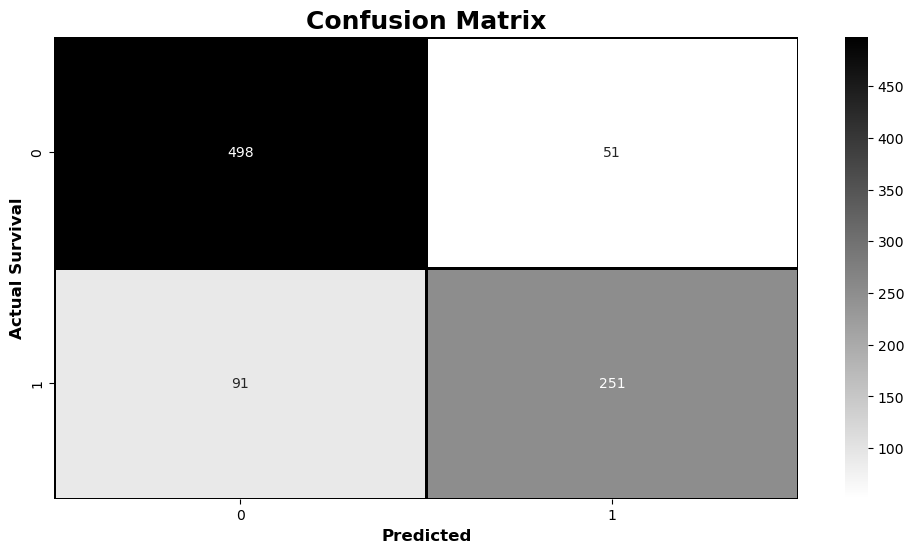

In [86]:
f, ax = plt.subplots(figsize = (12, 6))

sns.heatmap(conf_mat_list[selection],
            annot = True,
            fmt = ',.0f',
            cmap = 'binary',
            linewidths = 1, 
            linecolor = 'black',
            cbar_kws = {'format': mtick.StrMethodFormatter('{x:,.0f}')},
            ax = ax)
plt.title('Confusion Matrix', fontdict = plot_title_dict)
plt.ylabel('Actual Survival', fontdict = plot_axis_dict)
plt.xlabel('Predicted', fontdict = plot_axis_dict)
plt.show()

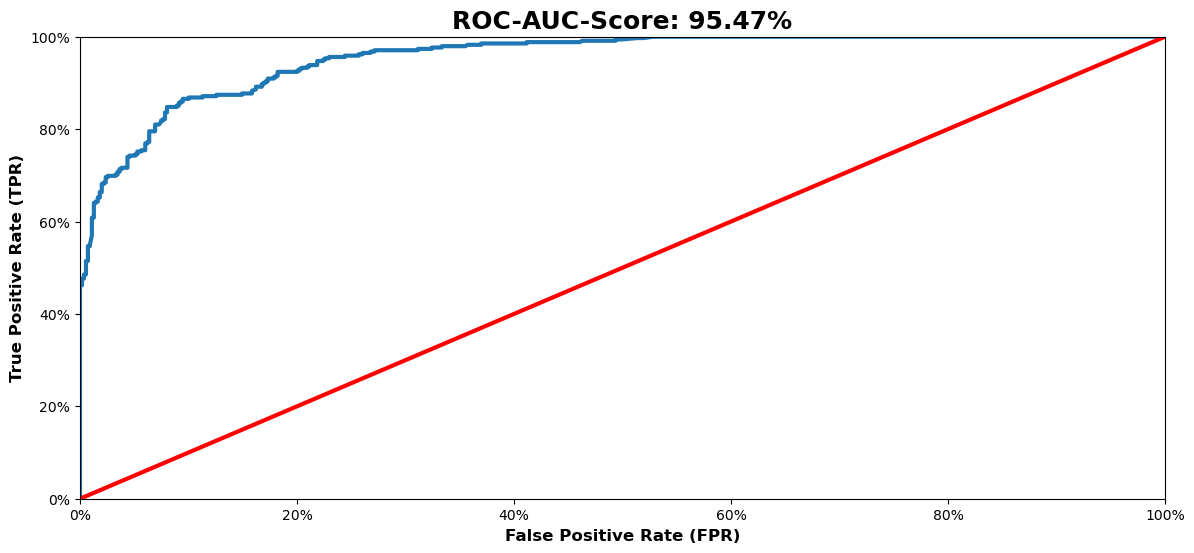

In [87]:
f, ax = plt.subplots(figsize = (14, 6))
plt.plot(fpr_list[selection], 
         tpr_list[selection], 
         linewidth = 3, label = None)
plt.plot([0, 1], [0, 1], 'r', linewidth = 3)
plt.axis([0, 1, 0, 1])
plt.title('ROC-AUC-Score: ' +"{:.2%}".format(roc_auc_list[selection]), fontdict = plot_title_dict)
plt.xlabel('False Positive Rate (FPR)', fontdict = plot_axis_dict)
plt.ylabel('True Positive Rate (TPR)', fontdict = plot_axis_dict)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
plt.show()

# 12. Submit to Kaggle

References:
1. https://www.kaggle.com/docs/api
2. https://www.youtube.com/watch?v=gkEbaMgvLs8

In [88]:
print('Selected Model: ' + final_model)
print('Make sure to update comment on submission')
submission_df.to_csv('submission.csv', index = False)

Selected Model: Ensemble: SVC + RF Tuned + XGBoost Tuned (33% - 33% - 33%)
Make sure to update comment on submission


In [89]:
# !kaggle competitions submit -c titanic -f submission.csv -m svm_rfht_xgbht

# 13. Compare Public Score with Leaderboard

Public Scores:
1. Commit **svm_rfht_xgbht** is Ensemble: SVC + RF Tuned + XGBoost Tuned (33% - 33% - 33%) with a public score of **0.79186**

Public score: 79.186%
Mean score: 77.305%
Median score: 77.511%
5.1% are better
94.9% are equal or worse
Out of 15,448 scores, 791 scored higher.


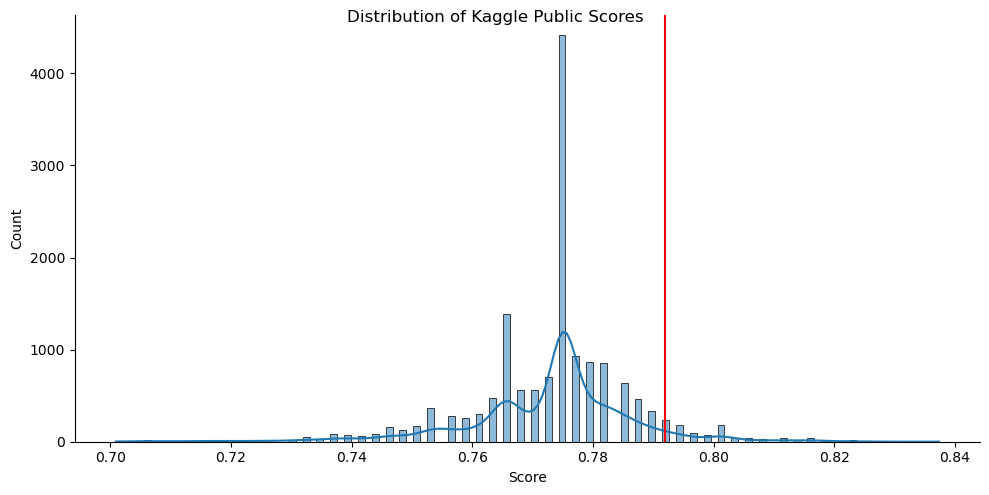

In [90]:
public_score = 0.79186

scores_df = pd.read_csv(kaggle_path + '/titanic-leaderboard/titanic-publicleaderboard-2025-11-28T01-56-53.csv')
scores_df = scores_df[(scores_df['Score'] >= 0.70) & (scores_df['Score'] <= 0.85)].reset_index(drop = True)

total_scores = scores_df.shape[0]
better_scores = scores_df[scores_df['Score'] > public_score].shape[0]
worse_scores = scores_df[scores_df['Score'] <= public_score].shape[0]
score_pct = better_scores / total_scores

print('Public score: ' + "{:.3%}".format(public_score))
print('Mean score: ' + "{:.3%}".format(scores_df['Score'].mean()))
print('Median score: ' + "{:.3%}".format(scores_df['Score'].median()))
print("{:.1%}".format(better_scores / total_scores) + ' are better')
print("{:.1%}".format(worse_scores / total_scores) + ' are equal or worse')
print('Out of ' + "{:,}".format(total_scores) + ' scores, ' + "{:,}".format(better_scores) + ' scored higher.')

sns.displot(data = scores_df, 
            x = 'Score', 
            kde = True,
            height = 5,
            aspect = 2)
plt.axvline(x = public_score, color = 'red')
plt.suptitle('Distribution of Kaggle Public Scores')
plt.show()